In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device='cuda:1'

In [3]:
H_filename = './source/BCH_15_11.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [4]:
class min_sum(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(min_sum, self).__init__()
        self.W_cv = torch.ones((num_iterations, num_edges))
        # self.W_cv = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_cv.requires_grad = True
        self.B_cv = torch.zeros((num_iterations, num_edges))
        # self.B_cv = torch.nn.Parameter(torch.abs(torch.zeros((num_iterations, num_edges))))
        # self.B_cv.requires_grad = True
        self.W_vc = torch.ones((num_iterations, num_edges))
        # self.W_vc = torch.nn.Parameter(torch.abs(torch.ones((num_iterations, num_edges))))
        # self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1])).to(device)       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device)
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [5]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5):
        super(Decoder, self).__init__()
        # self.W_cv = torch.ones((num_iterations, num_edges))
        self.W_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_cv.requires_grad = True
        # self.B_cv = torch.zeros((num_iterations, num_edges))
        self.B_cv = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.B_cv.requires_grad = True
        # self.W_vc = torch.ones((num_iterations, num_edges))
        self.W_vc = torch.nn.Parameter(torch.abs(torch.randn((num_iterations, num_edges))))
        self.W_vc.requires_grad = True
        
        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        # self.W_cv = torch.nn.Parameter(torch.abs(self.W_cv))
        # self.B_cv =torch.nn.Parameter(torch.abs(self.B_cv))
        # self.W_vc = torch.nn.Parameter(torch.abs(self.W_vc))
        
        # output = soft_input
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1]))       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1]))
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [6]:
def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in loader:
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)
        # clf.apply(constraints)

        # clf.W_cv = torch.nn.Parameter(torch.relu(clf.W_cv))
        # clf.B_cv = torch.nn.Parameter(torch.relu(clf.B_cv))
        # clf.W_vc = torch.nn.Parameter(torch.relu(clf.W_vc))
        # print(clf.W_cv[0])


        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

## Create dataloader

In [7]:
def gen():
    messages = np.random.randint(0,2,[train_size,k])
    codewords = messages @ G % 2
    BPSK_codewords = (0.5 - codewords.astype(np.float32)) * 2.0
    soft_input = np.zeros_like(BPSK_codewords)
    SNRs = np.arange(1,6)
    for i in range(0,len(SNRs)):
        sigma = np.sqrt(1. / (2 * (np.float(k)/np.float(n)) * 10**(SNRs[i]/10)))
        noise = sigma * np.random.randn(train_size//len(SNRs),n)
        start_idx = train_size*i//len(SNRs)
        end_idx = train_size*(i+1)//len(SNRs)
        soft_input[start_idx:end_idx,:] = BPSK_codewords[start_idx:end_idx,:] + noise
        soft_input = 2 * soft_input / (sigma**2)
    return soft_input, codewords
    
def update_loaders():


    soft_input_train, codewords_train = gen()
    train_X = torch.Tensor(soft_input_train) # transform to torch tensor
    train_y = torch.Tensor(codewords_train)
    training_dataset = torch.utils.data.TensorDataset(train_X, train_y) # create your datset
    training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20000, shuffle=True) # create your dataloader


    soft_input_test, codewords_test = gen()
    test_X = torch.Tensor(soft_input_test) # transform to torch tensor
    test_y = torch.Tensor(codewords_test)
    test_dataset = torch.utils.data.TensorDataset(test_X, test_y) # create your datset
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20000, shuffle=True) # create your dataloader
    return training_loader, test_loader

In [8]:
decoder = Decoder(num_iterations=5).to(device)
# opt = torch.optim.Adam(decoder.parameters(), lr=0.0025)
opt = torch.optim.SGD(decoder.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()

In [9]:
test_size = 100000
req_err = 500*n
SNRs = np.arange(-10,5)

In [25]:
# hard decisions, classic min-sum
ms = min_sum(num_iterations=5).to(device)

bit_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_bits_hard = torch.zeros(len(SNRs)).to(device)
bit_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_bits_min_sum = torch.zeros(len(SNRs)).to(device)
for i, snr in enumerate(SNRs):
            while bit_errors_min_sum[i] < req_err:
                messages = torch.randint(0, 2, (test_size, k))
                codewords = messages @ G % 2
                codewords = codewords.to(device)
                BPSK_codewords = (0.5 - codewords) * 2
                sigma = torch.sqrt(torch.tensor(1) / (2 * (k/n) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise
                bit_errors_hard[i] += torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) != codewords)
                bit_errors_min_sum[i] += torch.count_nonzero(torch.heaviside(ms(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_bits_hard[i] += test_size * n
                nb_bits_min_sum[i] += test_size * n
                print(f'SNR: {snr}, {100*bit_errors_min_sum[i]/req_err :.3f}%, test BER: {bit_errors_min_sum[i] / nb_bits_min_sum[i]}                ', end='\r')
            print('\n')

SNR: -10, 7271.880%, test BER: 0.3635939955711365                

SNR: -9, 6963.173%, test BER: 0.34815865755081177                

SNR: -8, 6627.280%, test BER: 0.3313640058040619                

SNR: -7, 6258.987%, test BER: 0.3129493296146393                

SNR: -6, 5851.520%, test BER: 0.29257598519325256                

SNR: -5, 5406.440%, test BER: 0.2703219950199127                

SNR: -4, 4894.827%, test BER: 0.24474133551120758                

SNR: -3, 4358.000%, test BER: 0.21789999306201935                

SNR: -2, 3723.613%, test BER: 0.18618066608905792                

SNR: -1, 3026.520%, test BER: 0.1513260006904602                

SNR: 0, 2310.173%, test BER: 0.11550866812467575                

SNR: 1, 1601.200%, test BER: 0.08005999773740768                

SNR: 2, 979.400%, test BER: 0.048969998955726624                

SNR: 3, 509.347%, test BER: 0.02546733245253563                

SNR: 4, 221.133%, test BER: 0.011056666262447834                



In [11]:
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self,module):
        if hasattr(module,'weight'):
            print("Entered")
            W_cv=module.W_cv
            W_cv = torch.clamp(W_cv, min=0)
            module.W_cv=W_cv
            B_cv=module.B_cv
            B_cv = torch.clamp(W_cv, min=0)
            module.B_cv=B_cv
            W_vc=module.W_vc
            W_vc = torch.clamp(W_vc, min=0)
            module.W_vc=W_vc

In [12]:
constraints=weightConstraint()

In [ ]:
train_size = 50000
n_upd = 500
bit_errors_nn = torch.zeros((n_upd, len(SNRs))).to(device)
nb_bits_nn = torch.zeros((n_upd, len(SNRs))).to(device)
ber_list = []

for upd in range(n_upd):
    print(f'TRAINING ITERATION #{upd+1}/{n_upd}')
    training_loader, test_loader = update_loaders()
    train(training_loader, test_loader, decoder, criterion, opt, n_epochs=3)

    if (np.mod(upd+1,5)==0):
        decoder.eval()
        for i, snr in enumerate(SNRs):
            while bit_errors_nn[upd][i] < req_err:
                messages = torch.randint(0, 2, (test_size, k))
                codewords = messages @ G % 2
                codewords = codewords.to(device)
                BPSK_codewords = (0.5 - codewords) * 2
                sigma = torch.sqrt(torch.tensor(1) / (2 * (np.float(k)/np.float(n)) * 10**(snr/10)))
                noise = sigma * torch.randn(test_size, n).to(device)
                soft_input = BPSK_codewords + noise
                bit_errors_nn[upd][i] += torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
                nb_bits_nn[upd][i] += test_size * n
                print(f'SNR: {snr}, {100*bit_errors_nn[upd][i]/req_err :.3f}%, test BER: {bit_errors_nn[upd][i] / nb_bits_nn[upd][i]}                ', end='\r')
            print('\n')
        ber_list.append((bit_errors_nn[upd,-1].cpu() / nb_bits_nn[upd,-1].cpu()).numpy())    
        np.savetxt('ber.txt', ber_list)

TRAINING ITERATION #1/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.886; train acc: 14.49; test loss: 17.880; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.37s/it]

[Epoch 2] train loss: 17.881; train acc: 14.49; test loss: 17.881; test acc: 14.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.37s/it]


[Epoch 3] train loss: 17.889; train acc: 14.49; test loss: 17.870; test acc: 14.49
TRAINING ITERATION #2/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.859; train acc: 14.49; test loss: 17.842; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.860; train acc: 14.49; test loss: 17.852; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.855; train acc: 14.49; test loss: 17.848; test acc: 14.50
TRAINING ITERATION #3/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.870; train acc: 14.49; test loss: 17.902; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.877; train acc: 14.49; test loss: 17.872; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.881; train acc: 14.49; test loss: 17.893; test acc: 14.50
TRAINING ITERATION #4/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.871; train acc: 14.48; test loss: 17.851; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.880; train acc: 14.49; test loss: 17.842; test acc: 14.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.860; train acc: 14.49; test loss: 17.863; test acc: 14.49
TRAINING ITERATION #5/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.880; train acc: 14.49; test loss: 17.894; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.865; train acc: 14.49; test loss: 17.899; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]

[Epoch 3] train loss: 17.882; train acc: 14.49; test loss: 17.900; test acc: 14.50
SNR: -10, 7043.960%, test BER: 0.3521980047225952                



SNR: -9, 6696.160%, test BER: 0.33480799198150635                

SNR: -8, 6321.987%, test BER: 0.3160993456840515                

SNR: -7, 5928.800%, test BER: 0.2964400053024292                

SNR: -6, 5483.173%, test BER: 0.27415865659713745                

SNR: -5, 5002.200%, test BER: 0.250110000371933                

SNR: -4, 4486.733%, test BER: 0.2243366688489914                

SNR: -3, 3938.787%, test BER: 0.19693933427333832                

SNR: -2, 3386.600%, test BER: 0.16933000087738037                

SNR: -1, 2804.707%, test BER: 0.14023533463478088                

SNR: 0, 2239.400%, test BER: 0.11196999996900558                

SNR: 1, 1700.693%, test BER: 0.08503466844558716                

SNR: 2, 1210.253%, test BER: 0.060512665659189224                

SNR: 3, 792.387%, test BER: 0.039619334042072296                

SNR: 4, 470.693%, test BER: 0.023534666746854782                

TRAINING ITERATION #6/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.873; train acc: 14.50; test loss: 17.841; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.876; train acc: 14.50; test loss: 17.835; test acc: 14.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.878; train acc: 14.50; test loss: 17.831; test acc: 14.49
TRAINING ITERATION #7/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.912; train acc: 14.49; test loss: 17.862; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.917; train acc: 14.49; test loss: 17.857; test acc: 14.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.909; train acc: 14.49; test loss: 17.868; test acc: 14.49
TRAINING ITERATION #8/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.945; train acc: 14.50; test loss: 17.886; test acc: 14.49


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.948; train acc: 14.50; test loss: 17.887; test acc: 14.49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.923; train acc: 14.50; test loss: 17.913; test acc: 14.49
TRAINING ITERATION #9/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.853; train acc: 14.50; test loss: 17.887; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.849; train acc: 14.50; test loss: 17.897; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.845; train acc: 14.50; test loss: 17.898; test acc: 14.50
TRAINING ITERATION #10/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.869; train acc: 14.50; test loss: 17.898; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.885; train acc: 14.50; test loss: 17.900; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]

[Epoch 3] train loss: 17.876; train acc: 14.50; test loss: 17.895; test acc: 14.50
SNR: -10, 7038.454%, test BER: 0.3519226610660553                



SNR: -9, 6708.120%, test BER: 0.33540600538253784                

SNR: -8, 6332.173%, test BER: 0.3166086673736572                

SNR: -7, 5917.773%, test BER: 0.29588866233825684                

SNR: -6, 5476.293%, test BER: 0.27381467819213867                

SNR: -5, 4985.520%, test BER: 0.24927599728107452                

SNR: -4, 4486.573%, test BER: 0.2243286669254303                

SNR: -3, 3940.733%, test BER: 0.19703666865825653                

SNR: -2, 3380.227%, test BER: 0.16901133954524994                

SNR: -1, 2817.400%, test BER: 0.14087000489234924                

SNR: 0, 2250.773%, test BER: 0.1125386655330658                

SNR: 1, 1695.027%, test BER: 0.08475133031606674                

SNR: 2, 1207.133%, test BER: 0.06035666540265083                

SNR: 3, 785.613%, test BER: 0.039280667901039124                

SNR: 4, 473.000%, test BER: 0.023649999871850014                

TRAINING ITERATION #11/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.885; train acc: 14.50; test loss: 17.849; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.880; train acc: 14.50; test loss: 17.858; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.872; train acc: 14.50; test loss: 17.840; test acc: 14.50
TRAINING ITERATION #12/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.836; train acc: 14.50; test loss: 17.885; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.843; train acc: 14.50; test loss: 17.883; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.840; train acc: 14.50; test loss: 17.894; test acc: 14.50
TRAINING ITERATION #13/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.864; train acc: 14.50; test loss: 17.862; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.858; train acc: 14.50; test loss: 17.863; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.868; train acc: 14.50; test loss: 17.880; test acc: 14.50
TRAINING ITERATION #14/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.857; train acc: 14.51; test loss: 17.862; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.873; train acc: 14.51; test loss: 17.871; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.869; train acc: 14.51; test loss: 17.866; test acc: 14.50
TRAINING ITERATION #15/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 17.899; train acc: 14.51; test loss: 17.907; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.910; train acc: 14.51; test loss: 17.897; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]

[Epoch 3] train loss: 17.893; train acc: 14.51; test loss: 17.902; test acc: 14.50
SNR: -10, 7049.827%, test BER: 0.3524913191795349                



SNR: -9, 6697.280%, test BER: 0.3348639905452728                

SNR: -8, 6338.133%, test BER: 0.3169066607952118                

SNR: -7, 5928.333%, test BER: 0.29641667008399963                

SNR: -6, 5472.173%, test BER: 0.27360865473747253                

SNR: -5, 5003.280%, test BER: 0.2501640021800995                

SNR: -4, 4458.760%, test BER: 0.22293800115585327                

SNR: -3, 3950.587%, test BER: 0.19752933084964752                

SNR: -2, 3372.893%, test BER: 0.16864466667175293                

SNR: -1, 2811.480%, test BER: 0.14057399332523346                

SNR: 0, 2240.800%, test BER: 0.11203999817371368                

SNR: 1, 1690.640%, test BER: 0.0845320001244545                

SNR: 2, 1206.440%, test BER: 0.060322001576423645                

SNR: 3, 791.933%, test BER: 0.039596665650606155                

SNR: 4, 466.600%, test BER: 0.023329999297857285                

TRAINING ITERATION #16/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.37s/it]

[Epoch 1] train loss: 17.909; train acc: 14.50; test loss: 17.898; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.909; train acc: 14.50; test loss: 17.897; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.905; train acc: 14.50; test loss: 17.904; test acc: 14.50
TRAINING ITERATION #17/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.872; train acc: 14.50; test loss: 17.825; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.888; train acc: 14.50; test loss: 17.849; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.904; train acc: 14.50; test loss: 17.833; test acc: 14.50
TRAINING ITERATION #18/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.40s/it]

[Epoch 1] train loss: 17.869; train acc: 14.51; test loss: 17.890; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.879; train acc: 14.51; test loss: 17.895; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.880; train acc: 14.51; test loss: 17.897; test acc: 14.50
TRAINING ITERATION #19/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.824; train acc: 14.51; test loss: 17.897; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.824; train acc: 14.51; test loss: 17.905; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.855; train acc: 14.51; test loss: 17.906; test acc: 14.50
TRAINING ITERATION #20/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.888; train acc: 14.50; test loss: 17.860; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.903; train acc: 14.50; test loss: 17.881; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.884; train acc: 14.50; test loss: 17.881; test acc: 14.50
SNR: -10, 7045.974%, test BER: 0.35229867696762085                



SNR: -9, 6697.573%, test BER: 0.3348786532878876                

SNR: -8, 6318.920%, test BER: 0.3159460127353668                

SNR: -7, 5913.653%, test BER: 0.2956826686859131                

SNR: -6, 5484.747%, test BER: 0.27423733472824097                

SNR: -5, 4998.493%, test BER: 0.2499246597290039                

SNR: -4, 4484.374%, test BER: 0.22421866655349731                

SNR: -3, 3944.680%, test BER: 0.19723400473594666                

SNR: -2, 3398.733%, test BER: 0.1699366718530655                

SNR: -1, 2806.213%, test BER: 0.14031066000461578                

SNR: 0, 2235.533%, test BER: 0.11177666485309601                

SNR: 1, 1691.840%, test BER: 0.08459199965000153                

SNR: 2, 1201.573%, test BER: 0.06007866561412811                

SNR: 3, 789.613%, test BER: 0.03948066756129265                

SNR: 4, 470.613%, test BER: 0.023530665785074234                

TRAINING ITERATION #21/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.837; train acc: 14.50; test loss: 17.846; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.826; train acc: 14.50; test loss: 17.841; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.840; train acc: 14.50; test loss: 17.838; test acc: 14.50
TRAINING ITERATION #22/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.868; train acc: 14.50; test loss: 17.860; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.870; train acc: 14.50; test loss: 17.865; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.860; train acc: 14.50; test loss: 17.856; test acc: 14.51
TRAINING ITERATION #23/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.865; train acc: 14.51; test loss: 17.857; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.871; train acc: 14.50; test loss: 17.848; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.864; train acc: 14.51; test loss: 17.867; test acc: 14.50
TRAINING ITERATION #24/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.885; train acc: 14.51; test loss: 17.869; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.879; train acc: 14.51; test loss: 17.871; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.890; train acc: 14.51; test loss: 17.871; test acc: 14.51
TRAINING ITERATION #25/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.853; train acc: 14.50; test loss: 17.876; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.867; train acc: 14.50; test loss: 17.879; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.880; train acc: 14.50; test loss: 17.862; test acc: 14.51
SNR: -10, 7049.867%, test BER: 0.3524933457374573                



SNR: -9, 6705.747%, test BER: 0.33528733253479004                

SNR: -8, 6330.187%, test BER: 0.31650933623313904                

SNR: -7, 5913.920%, test BER: 0.2956959903240204                

SNR: -6, 5474.947%, test BER: 0.2737473249435425                

SNR: -5, 4998.454%, test BER: 0.24992266297340393                

SNR: -4, 4485.400%, test BER: 0.22427000105381012                

SNR: -3, 3940.987%, test BER: 0.1970493346452713                

SNR: -2, 3382.707%, test BER: 0.16913533210754395                

SNR: -1, 2798.453%, test BER: 0.13992266356945038                

SNR: 0, 2245.960%, test BER: 0.11229799687862396                

SNR: 1, 1683.107%, test BER: 0.08415533602237701                

SNR: 2, 1202.760%, test BER: 0.060137998312711716                

SNR: 3, 785.160%, test BER: 0.03925799950957298                

SNR: 4, 467.133%, test BER: 0.023356666788458824                

TRAINING ITERATION #26/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.908; train acc: 14.51; test loss: 17.897; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.891; train acc: 14.51; test loss: 17.891; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.898; train acc: 14.51; test loss: 17.899; test acc: 14.50
TRAINING ITERATION #27/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.815; train acc: 14.51; test loss: 17.864; test acc: 14.50


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.814; train acc: 14.51; test loss: 17.874; test acc: 14.50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.820; train acc: 14.51; test loss: 17.874; test acc: 14.51
TRAINING ITERATION #28/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.873; train acc: 14.51; test loss: 17.875; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.845; train acc: 14.51; test loss: 17.893; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.875; train acc: 14.51; test loss: 17.891; test acc: 14.51
TRAINING ITERATION #29/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.904; train acc: 14.50; test loss: 17.888; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.907; train acc: 14.50; test loss: 17.860; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.891; train acc: 14.50; test loss: 17.884; test acc: 14.51
TRAINING ITERATION #30/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.893; train acc: 14.50; test loss: 17.873; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.879; train acc: 14.50; test loss: 17.889; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.904; train acc: 14.51; test loss: 17.862; test acc: 14.51
SNR: -10, 7035.707%, test BER: 0.3517853319644928                



SNR: -9, 6704.520%, test BER: 0.33522599935531616                

SNR: -8, 6325.267%, test BER: 0.316263347864151                

SNR: -7, 5922.013%, test BER: 0.2961006760597229                

SNR: -6, 5456.680%, test BER: 0.27283400297164917                

SNR: -5, 5001.720%, test BER: 0.2500860095024109                

SNR: -4, 4492.653%, test BER: 0.22463266551494598                

SNR: -3, 3942.187%, test BER: 0.19710932672023773                

SNR: -2, 3384.307%, test BER: 0.1692153364419937                

SNR: -1, 2808.173%, test BER: 0.14040866494178772                

SNR: 0, 2222.893%, test BER: 0.11114466935396194                

SNR: 1, 1691.040%, test BER: 0.08455199748277664                

SNR: 2, 1194.667%, test BER: 0.05973333492875099                

SNR: 3, 783.053%, test BER: 0.03915266692638397                

SNR: 4, 464.827%, test BER: 0.023241333663463593                

TRAINING ITERATION #31/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.872; train acc: 14.52; test loss: 17.845; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.891; train acc: 14.52; test loss: 17.853; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.878; train acc: 14.52; test loss: 17.851; test acc: 14.52
TRAINING ITERATION #32/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.799; train acc: 14.51; test loss: 17.884; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.800; train acc: 14.51; test loss: 17.860; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.793; train acc: 14.51; test loss: 17.883; test acc: 14.52
TRAINING ITERATION #33/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.860; train acc: 14.51; test loss: 17.881; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.853; train acc: 14.51; test loss: 17.869; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.857; train acc: 14.51; test loss: 17.848; test acc: 14.52
TRAINING ITERATION #34/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.889; train acc: 14.51; test loss: 17.877; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.882; train acc: 14.51; test loss: 17.875; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.900; train acc: 14.51; test loss: 17.874; test acc: 14.51
TRAINING ITERATION #35/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.827; train acc: 14.51; test loss: 17.892; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.855; train acc: 14.51; test loss: 17.897; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.848; train acc: 14.51; test loss: 17.899; test acc: 14.51


SNR: -10, 7049.027%, test BER: 0.3524513244628906                

SNR: -9, 6701.227%, test BER: 0.33506134152412415                

SNR: -8, 6339.013%, test BER: 0.3169506788253784                

SNR: -7, 5924.374%, test BER: 0.2962186634540558                

SNR: -6, 5469.760%, test BER: 0.27348798513412476                

SNR: -5, 4995.894%, test BER: 0.24979466199874878                

SNR: -4, 4488.093%, test BER: 0.22440466284751892                

SNR: -3, 3947.253%, test BER: 0.19736266136169434                

SNR: -2, 3372.493%, test BER: 0.1686246693134308                

SNR: -1, 2802.627%, test BER: 0.14013133943080902                

SNR: 0, 2239.013%, test BER: 0.11195066571235657                

SNR: 1, 1684.867%, test BER: 0.08424333482980728                

SNR: 2, 1202.627%, test BER: 0.06013133376836777                

SNR: 3, 785.653%, test BER: 0.0392826683819294                

SNR: 4, 464.080%, test BER: 0.023204000666737556                

TRAIN

 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.888; train acc: 14.52; test loss: 17.892; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.873; train acc: 14.52; test loss: 17.893; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.871; train acc: 14.52; test loss: 17.888; test acc: 14.51
TRAINING ITERATION #37/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.879; train acc: 14.52; test loss: 17.917; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.893; train acc: 14.52; test loss: 17.932; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.870; train acc: 14.52; test loss: 17.903; test acc: 14.51
TRAINING ITERATION #38/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.854; train acc: 14.52; test loss: 17.854; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.857; train acc: 14.52; test loss: 17.865; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.856; train acc: 14.52; test loss: 17.864; test acc: 14.51
TRAINING ITERATION #39/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.873; train acc: 14.51; test loss: 17.879; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.874; train acc: 14.51; test loss: 17.892; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.883; train acc: 14.51; test loss: 17.894; test acc: 14.51
TRAINING ITERATION #40/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.864; train acc: 14.51; test loss: 17.834; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.881; train acc: 14.51; test loss: 17.841; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.878; train acc: 14.51; test loss: 17.842; test acc: 14.51
SNR: -10, 7046.760%, test BER: 0.3523379862308502                



SNR: -9, 6700.920%, test BER: 0.3350459933280945                

SNR: -8, 6333.480%, test BER: 0.31667399406433105                

SNR: -7, 5929.227%, test BER: 0.2964613437652588                

SNR: -6, 5471.813%, test BER: 0.27359065413475037                

SNR: -5, 4976.854%, test BER: 0.24884267151355743                

SNR: -4, 4490.840%, test BER: 0.22454200685024261                

SNR: -3, 3932.653%, test BER: 0.19663266837596893                

SNR: -2, 3373.333%, test BER: 0.16866666078567505                

SNR: -1, 2804.373%, test BER: 0.14021866023540497                

SNR: 0, 2235.587%, test BER: 0.11177933216094971                

SNR: 1, 1682.707%, test BER: 0.08413533121347427                

SNR: 2, 1193.547%, test BER: 0.059677332639694214                

SNR: 3, 782.227%, test BER: 0.03911133483052254                

SNR: 4, 458.933%, test BER: 0.022946666926145554                

TRAINING ITERATION #41/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.886; train acc: 14.51; test loss: 17.852; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.873; train acc: 14.51; test loss: 17.836; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.870; train acc: 14.51; test loss: 17.823; test acc: 14.51
TRAINING ITERATION #42/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.899; train acc: 14.51; test loss: 17.877; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.888; train acc: 14.51; test loss: 17.868; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.885; train acc: 14.51; test loss: 17.881; test acc: 14.51
TRAINING ITERATION #43/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.871; train acc: 14.51; test loss: 17.854; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.899; train acc: 14.51; test loss: 17.841; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.865; train acc: 14.51; test loss: 17.856; test acc: 14.52
TRAINING ITERATION #44/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.870; train acc: 14.51; test loss: 17.922; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.882; train acc: 14.51; test loss: 17.923; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.887; train acc: 14.51; test loss: 17.914; test acc: 14.51
TRAINING ITERATION #45/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.891; train acc: 14.51; test loss: 17.880; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.892; train acc: 14.51; test loss: 17.885; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.884; train acc: 14.51; test loss: 17.897; test acc: 14.52
SNR: -10, 7052.494%, test BER: 0.35262465476989746                



SNR: -9, 6716.480%, test BER: 0.33582401275634766                

SNR: -8, 6331.600%, test BER: 0.31657999753952026                

SNR: -7, 5925.240%, test BER: 0.2962619960308075                

SNR: -6, 5487.280%, test BER: 0.27436399459838867                

SNR: -5, 4997.600%, test BER: 0.24988000094890594                

SNR: -4, 4497.133%, test BER: 0.2248566597700119                

SNR: -3, 3939.587%, test BER: 0.1969793289899826                

SNR: -2, 3371.467%, test BER: 0.16857333481311798                

SNR: -1, 2799.813%, test BER: 0.1399906724691391                

SNR: 0, 2214.920%, test BER: 0.11074600368738174                

SNR: 1, 1686.880%, test BER: 0.08434399962425232                

SNR: 2, 1188.707%, test BER: 0.05943533405661583                

SNR: 3, 779.787%, test BER: 0.03898933157324791                

SNR: 4, 459.093%, test BER: 0.0229546669870615                

TRAINING ITERATION #46/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.879; train acc: 14.51; test loss: 17.824; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.878; train acc: 14.51; test loss: 17.823; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.856; train acc: 14.51; test loss: 17.825; test acc: 14.51
TRAINING ITERATION #47/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.851; train acc: 14.51; test loss: 17.830; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.837; train acc: 14.51; test loss: 17.843; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.851; train acc: 14.51; test loss: 17.829; test acc: 14.52
TRAINING ITERATION #48/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.877; train acc: 14.51; test loss: 17.871; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.903; train acc: 14.51; test loss: 17.861; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.894; train acc: 14.51; test loss: 17.863; test acc: 14.51
TRAINING ITERATION #49/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.866; train acc: 14.51; test loss: 17.870; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.855; train acc: 14.51; test loss: 17.857; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.858; train acc: 14.51; test loss: 17.867; test acc: 14.52
TRAINING ITERATION #50/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.900; train acc: 14.51; test loss: 17.895; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.912; train acc: 14.51; test loss: 17.876; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]

[Epoch 3] train loss: 17.921; train acc: 14.51; test loss: 17.885; test acc: 14.52
SNR: -10, 7053.187%, test BER: 0.35265934467315674                



SNR: -9, 6698.867%, test BER: 0.33494332432746887                

SNR: -8, 6340.400%, test BER: 0.3170199990272522                

SNR: -7, 5923.013%, test BER: 0.29615065455436707                

SNR: -6, 5465.867%, test BER: 0.2732933461666107                

SNR: -5, 4996.347%, test BER: 0.24981732666492462                

SNR: -4, 4484.827%, test BER: 0.22424133121967316                

SNR: -3, 3941.480%, test BER: 0.19707399606704712                

SNR: -2, 3366.373%, test BER: 0.16831867396831512                

SNR: -1, 2811.547%, test BER: 0.14057733118534088                

SNR: 0, 2222.427%, test BER: 0.11112133413553238                

SNR: 1, 1674.560%, test BER: 0.08372800052165985                

SNR: 2, 1185.733%, test BER: 0.05928666517138481                

SNR: 3, 770.947%, test BER: 0.038547333329916                

SNR: 4, 451.413%, test BER: 0.022570665925741196                

TRAINING ITERATION #51/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.865; train acc: 14.51; test loss: 17.876; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.884; train acc: 14.51; test loss: 17.873; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.879; train acc: 14.51; test loss: 17.864; test acc: 14.51
TRAINING ITERATION #52/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.858; train acc: 14.52; test loss: 17.869; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.862; train acc: 14.52; test loss: 17.871; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.844; train acc: 14.52; test loss: 17.854; test acc: 14.51
TRAINING ITERATION #53/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.868; train acc: 14.51; test loss: 17.870; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.876; train acc: 14.51; test loss: 17.876; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.877; train acc: 14.51; test loss: 17.866; test acc: 14.51
TRAINING ITERATION #54/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.839; train acc: 14.52; test loss: 17.862; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.837; train acc: 14.52; test loss: 17.865; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.830; train acc: 14.52; test loss: 17.845; test acc: 14.51
TRAINING ITERATION #55/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.865; train acc: 14.52; test loss: 17.837; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.877; train acc: 14.52; test loss: 17.828; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.868; train acc: 14.52; test loss: 17.829; test acc: 14.52
SNR: -10, 7044.760%, test BER: 0.3522379994392395                



SNR: -9, 6711.320%, test BER: 0.3355660140514374                

SNR: -8, 6332.320%, test BER: 0.3166159987449646                

SNR: -7, 5924.627%, test BER: 0.29623132944107056                

SNR: -6, 5458.000%, test BER: 0.2728999853134155                

SNR: -5, 4996.267%, test BER: 0.24981333315372467                

SNR: -4, 4496.000%, test BER: 0.2248000055551529                

SNR: -3, 3947.040%, test BER: 0.19735200703144073                

SNR: -2, 3374.280%, test BER: 0.1687140017747879                

SNR: -1, 2803.587%, test BER: 0.1401793360710144                

SNR: 0, 2224.920%, test BER: 0.11124599725008011                

SNR: 1, 1680.867%, test BER: 0.08404333144426346                

SNR: 2, 1184.560%, test BER: 0.05922799929976463                

SNR: 3, 770.000%, test BER: 0.03849999979138374                

SNR: 4, 453.347%, test BER: 0.022667333483695984                

TRAINING ITERATION #56/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.902; train acc: 14.52; test loss: 17.863; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.900; train acc: 14.52; test loss: 17.859; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.883; train acc: 14.52; test loss: 17.865; test acc: 14.52
TRAINING ITERATION #57/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.864; train acc: 14.52; test loss: 17.851; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.857; train acc: 14.52; test loss: 17.846; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.850; train acc: 14.52; test loss: 17.849; test acc: 14.51
TRAINING ITERATION #58/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.859; train acc: 14.52; test loss: 17.879; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.855; train acc: 14.52; test loss: 17.866; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.849; train acc: 14.52; test loss: 17.870; test acc: 14.51
TRAINING ITERATION #59/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.844; train acc: 14.51; test loss: 17.863; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.838; train acc: 14.51; test loss: 17.889; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.37s/it]


[Epoch 3] train loss: 17.854; train acc: 14.51; test loss: 17.883; test acc: 14.52
TRAINING ITERATION #60/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.899; train acc: 14.53; test loss: 17.835; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.890; train acc: 14.53; test loss: 17.843; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.914; train acc: 14.53; test loss: 17.852; test acc: 14.52
SNR: -10, 7055.053%, test BER: 0.3527526557445526                



SNR: -9, 6700.000%, test BER: 0.33500000834465027                

SNR: -8, 6325.600%, test BER: 0.3162800073623657                

SNR: -7, 5921.680%, test BER: 0.2960839867591858                

SNR: -6, 5475.667%, test BER: 0.2737833261489868                

SNR: -5, 4991.480%, test BER: 0.24957400560379028                

SNR: -4, 4489.467%, test BER: 0.22447332739830017                

SNR: -3, 3950.760%, test BER: 0.19753800332546234                

SNR: -2, 3377.227%, test BER: 0.16886132955551147                

SNR: -1, 2781.760%, test BER: 0.1390880048274994                

SNR: 0, 2219.400%, test BER: 0.11096999794244766                

SNR: 1, 1677.000%, test BER: 0.08384999632835388                

SNR: 2, 1180.627%, test BER: 0.05903133377432823                

SNR: 3, 774.640%, test BER: 0.038731999695301056                

SNR: 4, 448.667%, test BER: 0.022433333098888397                

TRAINING ITERATION #61/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.886; train acc: 14.52; test loss: 17.848; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.876; train acc: 14.52; test loss: 17.849; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.880; train acc: 14.52; test loss: 17.853; test acc: 14.52
TRAINING ITERATION #62/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.901; train acc: 14.52; test loss: 17.861; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.896; train acc: 14.52; test loss: 17.876; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.900; train acc: 14.52; test loss: 17.876; test acc: 14.53
TRAINING ITERATION #63/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.855; train acc: 14.51; test loss: 17.866; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.866; train acc: 14.51; test loss: 17.858; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.846; train acc: 14.51; test loss: 17.844; test acc: 14.52
TRAINING ITERATION #64/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.883; train acc: 14.52; test loss: 17.855; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.865; train acc: 14.52; test loss: 17.870; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.867; train acc: 14.52; test loss: 17.866; test acc: 14.51
TRAINING ITERATION #65/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.870; train acc: 14.52; test loss: 17.878; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.866; train acc: 14.52; test loss: 17.879; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.873; train acc: 14.52; test loss: 17.891; test acc: 14.52
SNR: -10, 7049.934%, test BER: 0.3524966537952423                



SNR: -9, 6707.560%, test BER: 0.3353779911994934                

SNR: -8, 6339.027%, test BER: 0.31695133447647095                

SNR: -7, 5925.454%, test BER: 0.2962726652622223                

SNR: -6, 5488.040%, test BER: 0.274401992559433                

SNR: -5, 4991.813%, test BER: 0.249590665102005                

SNR: -4, 4478.720%, test BER: 0.22393600642681122                

SNR: -3, 3955.587%, test BER: 0.1977793276309967                

SNR: -2, 3377.333%, test BER: 0.16886666417121887                

SNR: -1, 2799.307%, test BER: 0.13996534049510956                

SNR: 0, 2220.093%, test BER: 0.11100466549396515                

SNR: 1, 1680.347%, test BER: 0.08401733636856079                

SNR: 2, 1177.880%, test BER: 0.05889400094747543                

SNR: 3, 762.853%, test BER: 0.03814266622066498                

SNR: 4, 449.893%, test BER: 0.022494666278362274                

TRAINING ITERATION #66/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.851; train acc: 14.52; test loss: 17.861; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.834; train acc: 14.52; test loss: 17.863; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.834; train acc: 14.52; test loss: 17.871; test acc: 14.52
TRAINING ITERATION #67/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.847; train acc: 14.52; test loss: 17.902; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.835; train acc: 14.52; test loss: 17.872; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.838; train acc: 14.52; test loss: 17.892; test acc: 14.52
TRAINING ITERATION #68/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.822; train acc: 14.52; test loss: 17.868; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.820; train acc: 14.52; test loss: 17.861; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.811; train acc: 14.52; test loss: 17.860; test acc: 14.52
TRAINING ITERATION #69/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.838; train acc: 14.52; test loss: 17.873; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.855; train acc: 14.52; test loss: 17.857; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.851; train acc: 14.52; test loss: 17.880; test acc: 14.52
TRAINING ITERATION #70/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.831; train acc: 14.52; test loss: 17.846; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.837; train acc: 14.52; test loss: 17.845; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.833; train acc: 14.52; test loss: 17.842; test acc: 14.52
SNR: -10, 7047.653%, test BER: 0.3523826599121094                



SNR: -9, 6703.880%, test BER: 0.3351939916610718                

SNR: -8, 6335.854%, test BER: 0.31679266691207886                

SNR: -7, 5923.987%, test BER: 0.29619932174682617                

SNR: -6, 5470.146%, test BER: 0.27350732684135437                

SNR: -5, 5002.840%, test BER: 0.25014200806617737                

SNR: -4, 4509.773%, test BER: 0.22548866271972656                

SNR: -3, 3951.240%, test BER: 0.19756199419498444                

SNR: -2, 3375.227%, test BER: 0.16876132786273956                

SNR: -1, 2806.760%, test BER: 0.1403380036354065                

SNR: 0, 2211.640%, test BER: 0.11058200150728226                

SNR: 1, 1667.333%, test BER: 0.08336666971445084                

SNR: 2, 1179.427%, test BER: 0.058971334248781204                

SNR: 3, 766.880%, test BER: 0.03834399953484535                

SNR: 4, 447.200%, test BER: 0.022360000759363174                

TRAINING ITERATION #71/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.862; train acc: 14.52; test loss: 17.882; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.854; train acc: 14.52; test loss: 17.883; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.856; train acc: 14.52; test loss: 17.882; test acc: 14.53
TRAINING ITERATION #72/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.862; train acc: 14.52; test loss: 17.872; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.851; train acc: 14.52; test loss: 17.865; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.868; train acc: 14.52; test loss: 17.861; test acc: 14.52
TRAINING ITERATION #73/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.902; train acc: 14.52; test loss: 17.872; test acc: 14.51


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.892; train acc: 14.52; test loss: 17.867; test acc: 14.51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.894; train acc: 14.52; test loss: 17.861; test acc: 14.51
TRAINING ITERATION #74/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.875; train acc: 14.52; test loss: 17.864; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.882; train acc: 14.52; test loss: 17.854; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.870; train acc: 14.52; test loss: 17.855; test acc: 14.52
TRAINING ITERATION #75/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.865; train acc: 14.52; test loss: 17.865; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.866; train acc: 14.52; test loss: 17.871; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.858; train acc: 14.52; test loss: 17.848; test acc: 14.53
SNR: -10, 7044.467%, test BER: 0.35222333669662476                



SNR: -9, 6702.507%, test BER: 0.3351253271102905                

SNR: -8, 6334.480%, test BER: 0.3167240023612976                

SNR: -7, 5925.507%, test BER: 0.2962753474712372                

SNR: -6, 5465.934%, test BER: 0.27329665422439575                

SNR: -5, 4993.267%, test BER: 0.2496633380651474                

SNR: -4, 4497.400%, test BER: 0.2248699963092804                

SNR: -3, 3938.200%, test BER: 0.19690999388694763                

SNR: -2, 3372.973%, test BER: 0.16864866018295288                

SNR: -1, 2796.987%, test BER: 0.13984933495521545                

SNR: 0, 2215.507%, test BER: 0.11077533662319183                

SNR: 1, 1678.773%, test BER: 0.08393866568803787                

SNR: 2, 1173.733%, test BER: 0.05868666619062424                

SNR: 3, 758.693%, test BER: 0.037934668362140656                

SNR: 4, 446.880%, test BER: 0.02234400063753128                

TRAINING ITERATION #76/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.861; train acc: 14.52; test loss: 17.853; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.840; train acc: 14.52; test loss: 17.856; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.862; train acc: 14.52; test loss: 17.863; test acc: 14.52
TRAINING ITERATION #77/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.841; train acc: 14.52; test loss: 17.860; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.862; train acc: 14.52; test loss: 17.853; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.840; train acc: 14.52; test loss: 17.863; test acc: 14.52
TRAINING ITERATION #78/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.894; train acc: 14.52; test loss: 17.925; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.910; train acc: 14.52; test loss: 17.926; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.896; train acc: 14.52; test loss: 17.945; test acc: 14.52
TRAINING ITERATION #79/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.873; train acc: 14.53; test loss: 17.881; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.879; train acc: 14.53; test loss: 17.877; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.866; train acc: 14.53; test loss: 17.877; test acc: 14.52
TRAINING ITERATION #80/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.849; train acc: 14.52; test loss: 17.852; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.836; train acc: 14.52; test loss: 17.855; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.853; train acc: 14.52; test loss: 17.837; test acc: 14.53
SNR: -10, 7056.733%, test BER: 0.3528366684913635                



SNR: -9, 6708.520%, test BER: 0.33542600274086                

SNR: -8, 6346.640%, test BER: 0.317331999540329                

SNR: -7, 5940.013%, test BER: 0.2970006763935089                

SNR: -6, 5474.307%, test BER: 0.2737153470516205                

SNR: -5, 4980.974%, test BER: 0.24904866516590118                

SNR: -4, 4483.720%, test BER: 0.2241860032081604                

SNR: -3, 3933.880%, test BER: 0.1966940015554428                

SNR: -2, 3368.747%, test BER: 0.16843733191490173                

SNR: -1, 2791.720%, test BER: 0.13958600163459778                

SNR: 0, 2211.053%, test BER: 0.11055266857147217                

SNR: 1, 1658.173%, test BER: 0.08290866762399673                

SNR: 2, 1166.467%, test BER: 0.05832333490252495                

SNR: 3, 753.387%, test BER: 0.037669334560632706                

SNR: 4, 445.747%, test BER: 0.022287333384156227                

TRAINING ITERATION #81/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.892; train acc: 14.52; test loss: 17.823; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.900; train acc: 14.52; test loss: 17.821; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.898; train acc: 14.52; test loss: 17.828; test acc: 14.52
TRAINING ITERATION #82/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.876; train acc: 14.52; test loss: 17.842; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.872; train acc: 14.52; test loss: 17.841; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.881; train acc: 14.52; test loss: 17.826; test acc: 14.52
TRAINING ITERATION #83/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.888; train acc: 14.52; test loss: 17.845; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.865; train acc: 14.52; test loss: 17.856; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.877; train acc: 14.52; test loss: 17.839; test acc: 14.52
TRAINING ITERATION #84/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.879; train acc: 14.53; test loss: 17.904; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.873; train acc: 14.53; test loss: 17.900; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.878; train acc: 14.53; test loss: 17.890; test acc: 14.52
TRAINING ITERATION #85/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.885; train acc: 14.53; test loss: 17.827; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.889; train acc: 14.53; test loss: 17.819; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.896; train acc: 14.53; test loss: 17.829; test acc: 14.53
SNR: -10, 7058.280%, test BER: 0.3529140055179596                



SNR: -9, 6720.760%, test BER: 0.3360379934310913                

SNR: -8, 6336.454%, test BER: 0.31682267785072327                

SNR: -7, 5913.093%, test BER: 0.29565465450286865                

SNR: -6, 5478.253%, test BER: 0.2739126682281494                

SNR: -5, 5009.894%, test BER: 0.25049465894699097                

SNR: -4, 4493.013%, test BER: 0.22465066611766815                

SNR: -3, 3915.027%, test BER: 0.1957513391971588                

SNR: -2, 3374.067%, test BER: 0.1687033325433731                

SNR: -1, 2796.667%, test BER: 0.13983333110809326                

SNR: 0, 2222.493%, test BER: 0.1111246645450592                

SNR: 1, 1668.693%, test BER: 0.08343466371297836                

SNR: 2, 1178.520%, test BER: 0.05892600119113922                

SNR: 3, 754.280%, test BER: 0.037714000791311264                

SNR: 4, 443.107%, test BER: 0.022155333310365677                

TRAINING ITERATION #86/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.837; train acc: 14.53; test loss: 17.845; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.837; train acc: 14.53; test loss: 17.834; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.843; train acc: 14.53; test loss: 17.840; test acc: 14.53
TRAINING ITERATION #87/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.903; train acc: 14.52; test loss: 17.868; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.893; train acc: 14.52; test loss: 17.865; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.899; train acc: 14.52; test loss: 17.869; test acc: 14.52
TRAINING ITERATION #88/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.856; train acc: 14.53; test loss: 17.919; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.844; train acc: 14.53; test loss: 17.919; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.859; train acc: 14.53; test loss: 17.901; test acc: 14.53
TRAINING ITERATION #89/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.857; train acc: 14.53; test loss: 17.894; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.859; train acc: 14.53; test loss: 17.903; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.857; train acc: 14.53; test loss: 17.909; test acc: 14.52
TRAINING ITERATION #90/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.863; train acc: 14.52; test loss: 17.835; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.850; train acc: 14.52; test loss: 17.834; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.855; train acc: 14.52; test loss: 17.837; test acc: 14.53
SNR: -10, 7053.947%, test BER: 0.35269734263420105                



SNR: -9, 6721.680%, test BER: 0.3360840082168579                

SNR: -8, 6333.080%, test BER: 0.3166539967060089                

SNR: -7, 5918.907%, test BER: 0.29594534635543823                

SNR: -6, 5476.120%, test BER: 0.27380600571632385                

SNR: -5, 4989.840%, test BER: 0.24949200451374054                

SNR: -4, 4477.987%, test BER: 0.22389933466911316                

SNR: -3, 3940.080%, test BER: 0.19700400531291962                

SNR: -2, 3372.173%, test BER: 0.1686086654663086                

SNR: -1, 2794.613%, test BER: 0.13973066210746765                

SNR: 0, 2214.747%, test BER: 0.11073733121156693                

SNR: 1, 1659.253%, test BER: 0.08296266943216324                

SNR: 2, 1160.253%, test BER: 0.058012668043375015                

SNR: 3, 748.573%, test BER: 0.03742866590619087                

SNR: 4, 439.213%, test BER: 0.0219606664031744                

TRAINING ITERATION #91/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.886; train acc: 14.52; test loss: 17.880; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.887; train acc: 14.52; test loss: 17.879; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.896; train acc: 14.52; test loss: 17.879; test acc: 14.53
TRAINING ITERATION #92/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.882; train acc: 14.53; test loss: 17.817; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.879; train acc: 14.53; test loss: 17.844; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.891; train acc: 14.53; test loss: 17.841; test acc: 14.52
TRAINING ITERATION #93/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.867; train acc: 14.53; test loss: 17.854; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.862; train acc: 14.53; test loss: 17.861; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.861; train acc: 14.53; test loss: 17.852; test acc: 14.52
TRAINING ITERATION #94/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.849; train acc: 14.52; test loss: 17.859; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.862; train acc: 14.52; test loss: 17.854; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.859; train acc: 14.52; test loss: 17.872; test acc: 14.53
TRAINING ITERATION #95/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.908; train acc: 14.52; test loss: 17.893; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.878; train acc: 14.52; test loss: 17.904; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.902; train acc: 14.52; test loss: 17.902; test acc: 14.53
SNR: -10, 7058.187%, test BER: 0.3529093265533447                



SNR: -9, 6710.080%, test BER: 0.3355039954185486                

SNR: -8, 6329.120%, test BER: 0.31645599007606506                

SNR: -7, 5924.693%, test BER: 0.296234667301178                

SNR: -6, 5472.414%, test BER: 0.2736206650733948                

SNR: -5, 4990.067%, test BER: 0.24950332939624786                

SNR: -4, 4482.454%, test BER: 0.22412267327308655                

SNR: -3, 3934.693%, test BER: 0.19673466682434082                

SNR: -2, 3374.720%, test BER: 0.16873599588871002                

SNR: -1, 2790.907%, test BER: 0.13954533636569977                

SNR: 0, 2208.093%, test BER: 0.11040467023849487                

SNR: 1, 1671.067%, test BER: 0.08355333656072617                

SNR: 2, 1172.520%, test BER: 0.058625999838113785                

SNR: 3, 755.667%, test BER: 0.03778333216905594                

SNR: 4, 445.573%, test BER: 0.022278666496276855                

TRAINING ITERATION #96/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.885; train acc: 14.52; test loss: 17.854; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.886; train acc: 14.52; test loss: 17.849; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.894; train acc: 14.52; test loss: 17.850; test acc: 14.52
TRAINING ITERATION #97/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.837; train acc: 14.52; test loss: 17.837; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.840; train acc: 14.52; test loss: 17.849; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.836; train acc: 14.52; test loss: 17.859; test acc: 14.52
TRAINING ITERATION #98/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.827; train acc: 14.52; test loss: 17.883; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.820; train acc: 14.52; test loss: 17.892; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.854; train acc: 14.52; test loss: 17.887; test acc: 14.53
TRAINING ITERATION #99/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.879; train acc: 14.53; test loss: 17.854; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.896; train acc: 14.53; test loss: 17.828; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.879; train acc: 14.53; test loss: 17.838; test acc: 14.53
TRAINING ITERATION #100/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.875; train acc: 14.54; test loss: 17.864; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.879; train acc: 14.54; test loss: 17.856; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.867; train acc: 14.54; test loss: 17.875; test acc: 14.53
SNR: -10, 7064.400%, test BER: 0.35321998596191406                



SNR: -9, 6706.747%, test BER: 0.3353373408317566                

SNR: -8, 6349.947%, test BER: 0.3174973428249359                

SNR: -7, 5925.374%, test BER: 0.29626867175102234                

SNR: -6, 5474.720%, test BER: 0.27373600006103516                

SNR: -5, 4991.840%, test BER: 0.24959200620651245                

SNR: -4, 4483.467%, test BER: 0.22417333722114563                

SNR: -3, 3952.933%, test BER: 0.19764666259288788                

SNR: -2, 3379.213%, test BER: 0.16896066069602966                

SNR: -1, 2790.560%, test BER: 0.13952800631523132                

SNR: 0, 2216.827%, test BER: 0.11084133386611938                

SNR: 1, 1663.733%, test BER: 0.08318666368722916                

SNR: 2, 1173.013%, test BER: 0.0586506649851799                

SNR: 3, 757.627%, test BER: 0.037881333380937576                

SNR: 4, 433.773%, test BER: 0.021688666194677353                

TRAINING ITERATION #101/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.860; train acc: 14.52; test loss: 17.846; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.870; train acc: 14.52; test loss: 17.845; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.875; train acc: 14.52; test loss: 17.848; test acc: 14.52
TRAINING ITERATION #102/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.862; train acc: 14.52; test loss: 17.844; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.878; train acc: 14.53; test loss: 17.866; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.870; train acc: 14.53; test loss: 17.842; test acc: 14.53
TRAINING ITERATION #103/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.916; train acc: 14.52; test loss: 17.835; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.903; train acc: 14.52; test loss: 17.843; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.910; train acc: 14.52; test loss: 17.856; test acc: 14.52
TRAINING ITERATION #104/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.842; train acc: 14.53; test loss: 17.887; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.849; train acc: 14.53; test loss: 17.885; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.831; train acc: 14.53; test loss: 17.896; test acc: 14.53
TRAINING ITERATION #105/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.859; train acc: 14.52; test loss: 17.890; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.873; train acc: 14.52; test loss: 17.891; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.869; train acc: 14.52; test loss: 17.873; test acc: 14.53
SNR: -10, 7048.587%, test BER: 0.3524293303489685                



SNR: -9, 6709.093%, test BER: 0.33545467257499695                

SNR: -8, 6319.854%, test BER: 0.31599265336990356                

SNR: -7, 5908.454%, test BER: 0.29542267322540283                

SNR: -6, 5471.493%, test BER: 0.27357468008995056                

SNR: -5, 5000.880%, test BER: 0.25004398822784424                

SNR: -4, 4472.374%, test BER: 0.22361867129802704                

SNR: -3, 3939.093%, test BER: 0.1969546675682068                

SNR: -2, 3379.760%, test BER: 0.16898800432682037                

SNR: -1, 2792.373%, test BER: 0.1396186649799347                

SNR: 0, 2210.733%, test BER: 0.11053666472434998                

SNR: 1, 1663.747%, test BER: 0.08318733423948288                

SNR: 2, 1170.213%, test BER: 0.058510664850473404                

SNR: 3, 749.440%, test BER: 0.03747199848294258                

SNR: 4, 437.520%, test BER: 0.021875999867916107                

TRAINING ITERATION #106/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.898; train acc: 14.53; test loss: 17.872; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.899; train acc: 14.53; test loss: 17.867; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.904; train acc: 14.53; test loss: 17.866; test acc: 14.52
TRAINING ITERATION #107/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.843; train acc: 14.53; test loss: 17.897; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.837; train acc: 14.53; test loss: 17.894; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.827; train acc: 14.53; test loss: 17.881; test acc: 14.53
TRAINING ITERATION #108/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.884; train acc: 14.53; test loss: 17.838; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.903; train acc: 14.53; test loss: 17.856; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.892; train acc: 14.53; test loss: 17.837; test acc: 14.52
TRAINING ITERATION #109/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.859; train acc: 14.53; test loss: 17.847; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.864; train acc: 14.53; test loss: 17.847; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.865; train acc: 14.53; test loss: 17.842; test acc: 14.53
TRAINING ITERATION #110/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.26s/it]

[Epoch 1] train loss: 17.854; train acc: 14.53; test loss: 17.858; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.857; train acc: 14.53; test loss: 17.845; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.854; train acc: 14.53; test loss: 17.835; test acc: 14.53
SNR: -10, 7033.414%, test BER: 0.35167065262794495                



SNR: -9, 6705.320%, test BER: 0.33526599407196045                

SNR: -8, 6346.974%, test BER: 0.3173486590385437                

SNR: -7, 5926.773%, test BER: 0.29633867740631104                

SNR: -6, 5475.894%, test BER: 0.27379468083381653                

SNR: -5, 4995.360%, test BER: 0.24976800382137299                

SNR: -4, 4477.093%, test BER: 0.223854660987854                

SNR: -3, 3928.920%, test BER: 0.1964460015296936                

SNR: -2, 3365.187%, test BER: 0.16825933754444122                

SNR: -1, 2789.360%, test BER: 0.1394679993391037                

SNR: 0, 2212.227%, test BER: 0.11061133444309235                

SNR: 1, 1665.120%, test BER: 0.08325599879026413                

SNR: 2, 1162.413%, test BER: 0.058120667934417725                

SNR: 3, 751.187%, test BER: 0.03755933418869972                

SNR: 4, 434.947%, test BER: 0.02174733392894268                

TRAINING ITERATION #111/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.871; train acc: 14.52; test loss: 17.827; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.866; train acc: 14.52; test loss: 17.825; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.892; train acc: 14.52; test loss: 17.825; test acc: 14.53
TRAINING ITERATION #112/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.843; train acc: 14.53; test loss: 17.862; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.814; train acc: 14.53; test loss: 17.836; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.834; train acc: 14.53; test loss: 17.847; test acc: 14.53
TRAINING ITERATION #113/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.873; train acc: 14.53; test loss: 17.852; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.881; train acc: 14.53; test loss: 17.823; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.869; train acc: 14.53; test loss: 17.849; test acc: 14.52
TRAINING ITERATION #114/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.837; train acc: 14.54; test loss: 17.895; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.840; train acc: 14.54; test loss: 17.897; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.838; train acc: 14.54; test loss: 17.905; test acc: 14.52
TRAINING ITERATION #115/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.868; train acc: 14.53; test loss: 17.860; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.844; train acc: 14.53; test loss: 17.858; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.861; train acc: 14.53; test loss: 17.878; test acc: 14.52
SNR: -10, 7037.813%, test BER: 0.3518906533718109                



SNR: -9, 6699.360%, test BER: 0.3349680006504059                

SNR: -8, 6347.800%, test BER: 0.31738999485969543                

SNR: -7, 5929.600%, test BER: 0.2964800000190735                

SNR: -6, 5472.454%, test BER: 0.27362266182899475                

SNR: -5, 5000.960%, test BER: 0.2500480115413666                

SNR: -4, 4462.867%, test BER: 0.2231433391571045                

SNR: -3, 3942.067%, test BER: 0.1971033364534378                

SNR: -2, 3360.467%, test BER: 0.16802333295345306                

SNR: -1, 2783.147%, test BER: 0.13915733993053436                

SNR: 0, 2219.160%, test BER: 0.11095800250768661                

SNR: 1, 1662.000%, test BER: 0.08309999853372574                

SNR: 2, 1170.720%, test BER: 0.05853600054979324                

SNR: 3, 749.773%, test BER: 0.0374886654317379                

SNR: 4, 436.627%, test BER: 0.02183133363723755                

TRAINING ITERATION #116/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.868; train acc: 14.52; test loss: 17.824; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.867; train acc: 14.53; test loss: 17.836; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.862; train acc: 14.53; test loss: 17.816; test acc: 14.52
TRAINING ITERATION #117/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.852; train acc: 14.52; test loss: 17.856; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.852; train acc: 14.52; test loss: 17.854; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.841; train acc: 14.52; test loss: 17.852; test acc: 14.53
TRAINING ITERATION #118/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.895; train acc: 14.53; test loss: 17.868; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.907; train acc: 14.53; test loss: 17.888; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.907; train acc: 14.53; test loss: 17.876; test acc: 14.53
TRAINING ITERATION #119/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.815; train acc: 14.53; test loss: 17.837; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.814; train acc: 14.53; test loss: 17.822; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.818; train acc: 14.53; test loss: 17.833; test acc: 14.53
TRAINING ITERATION #120/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.895; train acc: 14.53; test loss: 17.894; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.866; train acc: 14.53; test loss: 17.886; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.892; train acc: 14.53; test loss: 17.894; test acc: 14.53
SNR: -10, 7053.960%, test BER: 0.3526979982852936                



SNR: -9, 6706.707%, test BER: 0.3353353440761566                

SNR: -8, 6327.107%, test BER: 0.3163553476333618                

SNR: -7, 5925.414%, test BER: 0.2962706685066223                

SNR: -6, 5484.880%, test BER: 0.2742440104484558                

SNR: -5, 5007.227%, test BER: 0.2503613233566284                

SNR: -4, 4490.333%, test BER: 0.22451665997505188                

SNR: -3, 3941.707%, test BER: 0.19708533585071564                

SNR: -2, 3369.947%, test BER: 0.16849733889102936                

SNR: -1, 2789.973%, test BER: 0.13949866592884064                

SNR: 0, 2205.427%, test BER: 0.11027133464813232                

SNR: 1, 1664.173%, test BER: 0.08320866525173187                

SNR: 2, 1164.493%, test BER: 0.058224666863679886                

SNR: 3, 747.560%, test BER: 0.03737799823284149                

SNR: 4, 437.933%, test BER: 0.021896665915846825                

TRAINING ITERATION #121/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.880; train acc: 14.52; test loss: 17.893; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.879; train acc: 14.52; test loss: 17.892; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.890; train acc: 14.52; test loss: 17.910; test acc: 14.52
TRAINING ITERATION #122/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.889; train acc: 14.53; test loss: 17.851; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.893; train acc: 14.53; test loss: 17.858; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.884; train acc: 14.53; test loss: 17.860; test acc: 14.54
TRAINING ITERATION #123/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.814; train acc: 14.52; test loss: 17.816; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.819; train acc: 14.52; test loss: 17.812; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.824; train acc: 14.52; test loss: 17.812; test acc: 14.54
TRAINING ITERATION #124/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.865; train acc: 14.52; test loss: 17.877; test acc: 14.52


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.858; train acc: 14.52; test loss: 17.880; test acc: 14.52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.867; train acc: 14.52; test loss: 17.893; test acc: 14.52
TRAINING ITERATION #125/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.818; train acc: 14.53; test loss: 17.880; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.817; train acc: 14.53; test loss: 17.876; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.813; train acc: 14.53; test loss: 17.879; test acc: 14.53
SNR: -10, 7051.640%, test BER: 0.35258200764656067                



SNR: -9, 6711.720%, test BER: 0.3355860114097595                

SNR: -8, 6337.013%, test BER: 0.3168506622314453                

SNR: -7, 5908.693%, test BER: 0.2954346537590027                

SNR: -6, 5479.854%, test BER: 0.273992657661438                

SNR: -5, 5001.627%, test BER: 0.250081330537796                

SNR: -4, 4478.013%, test BER: 0.2239006608724594                

SNR: -3, 3945.147%, test BER: 0.19725733995437622                

SNR: -2, 3362.907%, test BER: 0.1681453287601471                

SNR: -1, 2784.493%, test BER: 0.13922466337680817                

SNR: 0, 2223.427%, test BER: 0.11117133498191833                

SNR: 1, 1658.520%, test BER: 0.08292599767446518                

SNR: 2, 1155.227%, test BER: 0.057761333882808685                

SNR: 3, 739.720%, test BER: 0.03698600083589554                

SNR: 4, 434.267%, test BER: 0.02171333320438862                

TRAINING ITERATION #126/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.817; train acc: 14.53; test loss: 17.846; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.818; train acc: 14.53; test loss: 17.844; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.814; train acc: 14.53; test loss: 17.849; test acc: 14.53
TRAINING ITERATION #127/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.873; train acc: 14.53; test loss: 17.846; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.865; train acc: 14.53; test loss: 17.843; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.867; train acc: 14.53; test loss: 17.857; test acc: 14.53
TRAINING ITERATION #128/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.26s/it]

[Epoch 1] train loss: 17.819; train acc: 14.54; test loss: 17.833; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.846; train acc: 14.54; test loss: 17.837; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


[Epoch 3] train loss: 17.845; train acc: 14.54; test loss: 17.827; test acc: 14.53
TRAINING ITERATION #129/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.866; train acc: 14.52; test loss: 17.874; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.867; train acc: 14.53; test loss: 17.892; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.866; train acc: 14.53; test loss: 17.903; test acc: 14.53
TRAINING ITERATION #130/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.868; train acc: 14.53; test loss: 17.900; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.862; train acc: 14.53; test loss: 17.888; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]

[Epoch 3] train loss: 17.854; train acc: 14.53; test loss: 17.884; test acc: 14.53
SNR: -10, 7041.613%, test BER: 0.35208067297935486                



SNR: -9, 6696.533%, test BER: 0.33482667803764343                

SNR: -8, 6346.013%, test BER: 0.3173006772994995                

SNR: -7, 5933.320%, test BER: 0.2966659963130951                

SNR: -6, 5475.560%, test BER: 0.2737779915332794                

SNR: -5, 4994.227%, test BER: 0.24971133470535278                

SNR: -4, 4488.067%, test BER: 0.22440333664417267                

SNR: -3, 3939.093%, test BER: 0.1969546675682068                

SNR: -2, 3366.013%, test BER: 0.16830067336559296                

SNR: -1, 2792.440%, test BER: 0.13962200284004211                

SNR: 0, 2213.413%, test BER: 0.11067066341638565                

SNR: 1, 1660.467%, test BER: 0.08302333205938339                

SNR: 2, 1162.040%, test BER: 0.05810200050473213                

SNR: 3, 748.507%, test BER: 0.03742533177137375                

SNR: 4, 432.747%, test BER: 0.021637333557009697                

TRAINING ITERATION #131/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.857; train acc: 14.53; test loss: 17.871; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.850; train acc: 14.53; test loss: 17.870; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.844; train acc: 14.53; test loss: 17.875; test acc: 14.54
TRAINING ITERATION #132/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.845; train acc: 14.53; test loss: 17.860; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.30s/it]

[Epoch 2] train loss: 17.850; train acc: 14.53; test loss: 17.871; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.840; train acc: 14.53; test loss: 17.860; test acc: 14.53
TRAINING ITERATION #133/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.816; train acc: 14.53; test loss: 17.882; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.824; train acc: 14.53; test loss: 17.886; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.819; train acc: 14.53; test loss: 17.897; test acc: 14.53
TRAINING ITERATION #134/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.887; train acc: 14.53; test loss: 17.845; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.889; train acc: 14.53; test loss: 17.852; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.884; train acc: 14.53; test loss: 17.848; test acc: 14.53
TRAINING ITERATION #135/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.859; train acc: 14.53; test loss: 17.891; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.840; train acc: 14.53; test loss: 17.880; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.838; train acc: 14.53; test loss: 17.897; test acc: 14.53
SNR: -10, 7048.133%, test BER: 0.35240668058395386                



SNR: -9, 6707.040%, test BER: 0.33535200357437134                

SNR: -8, 6324.560%, test BER: 0.3162280023097992                

SNR: -7, 5909.067%, test BER: 0.29545333981513977                

SNR: -6, 5486.120%, test BER: 0.2743059992790222                

SNR: -5, 5007.374%, test BER: 0.2503686547279358                

SNR: -4, 4464.347%, test BER: 0.22321733832359314                

SNR: -3, 3924.320%, test BER: 0.19621600210666656                

SNR: -2, 3364.093%, test BER: 0.168204665184021                

SNR: -1, 2796.133%, test BER: 0.13980667293071747                

SNR: 0, 2203.280%, test BER: 0.11016400158405304                

SNR: 1, 1655.467%, test BER: 0.08277333527803421                

SNR: 2, 1159.333%, test BER: 0.05796666815876961                

SNR: 3, 742.947%, test BER: 0.03714733198285103                

SNR: 4, 433.693%, test BER: 0.021684667095541954                

TRAINING ITERATION #136/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.867; train acc: 14.53; test loss: 17.893; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.875; train acc: 14.53; test loss: 17.906; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.871; train acc: 14.53; test loss: 17.908; test acc: 14.54
TRAINING ITERATION #137/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.859; train acc: 14.53; test loss: 17.910; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.855; train acc: 14.53; test loss: 17.905; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.853; train acc: 14.53; test loss: 17.898; test acc: 14.53
TRAINING ITERATION #138/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.890; train acc: 14.53; test loss: 17.866; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.890; train acc: 14.53; test loss: 17.865; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.896; train acc: 14.53; test loss: 17.854; test acc: 14.53
TRAINING ITERATION #139/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.904; train acc: 14.53; test loss: 17.881; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.876; train acc: 14.53; test loss: 17.879; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.897; train acc: 14.53; test loss: 17.875; test acc: 14.53
TRAINING ITERATION #140/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.874; train acc: 14.53; test loss: 17.878; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.883; train acc: 14.53; test loss: 17.872; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.882; train acc: 14.53; test loss: 17.868; test acc: 14.53
SNR: -10, 7045.400%, test BER: 0.3522700071334839                



SNR: -9, 6724.854%, test BER: 0.33624267578125                

SNR: -8, 6344.627%, test BER: 0.31723132729530334                

SNR: -7, 5926.667%, test BER: 0.29633334279060364                

SNR: -6, 5485.267%, test BER: 0.27426332235336304                

SNR: -5, 4990.773%, test BER: 0.24953866004943848                

SNR: -4, 4457.253%, test BER: 0.22286266088485718                

SNR: -3, 3936.613%, test BER: 0.1968306601047516                

SNR: -2, 3373.560%, test BER: 0.16867800056934357                

SNR: -1, 2785.773%, test BER: 0.13928866386413574                

SNR: 0, 2209.987%, test BER: 0.11049932986497879                

SNR: 1, 1654.040%, test BER: 0.08270200341939926                

SNR: 2, 1161.267%, test BER: 0.0580633319914341                

SNR: 3, 747.747%, test BER: 0.03738733381032944                

SNR: 4, 436.587%, test BER: 0.021829333156347275                

TRAINING ITERATION #141/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.858; train acc: 14.53; test loss: 17.880; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.866; train acc: 14.53; test loss: 17.892; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.873; train acc: 14.53; test loss: 17.870; test acc: 14.53
TRAINING ITERATION #142/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.780; train acc: 14.53; test loss: 17.838; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.791; train acc: 14.53; test loss: 17.843; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.787; train acc: 14.53; test loss: 17.832; test acc: 14.53
TRAINING ITERATION #143/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.855; train acc: 14.53; test loss: 17.872; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.861; train acc: 14.53; test loss: 17.866; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.864; train acc: 14.53; test loss: 17.880; test acc: 14.53
TRAINING ITERATION #144/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.868; train acc: 14.53; test loss: 17.905; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.855; train acc: 14.54; test loss: 17.883; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.848; train acc: 14.54; test loss: 17.894; test acc: 14.53
TRAINING ITERATION #145/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.858; train acc: 14.53; test loss: 17.881; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.853; train acc: 14.53; test loss: 17.874; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.855; train acc: 14.53; test loss: 17.884; test acc: 14.54
SNR: -10, 7044.000%, test BER: 0.3522000014781952                



SNR: -9, 6710.960%, test BER: 0.3355480134487152                

SNR: -8, 6336.587%, test BER: 0.3168293237686157                

SNR: -7, 5929.320%, test BER: 0.29646599292755127                

SNR: -6, 5489.693%, test BER: 0.27448466420173645                

SNR: -5, 4988.867%, test BER: 0.24944333732128143                

SNR: -4, 4476.013%, test BER: 0.2238006740808487                

SNR: -3, 3936.680%, test BER: 0.196833997964859                

SNR: -2, 3363.507%, test BER: 0.1681753396987915                

SNR: -1, 2788.373%, test BER: 0.13941866159439087                

SNR: 0, 2220.187%, test BER: 0.11100933700799942                

SNR: 1, 1662.800%, test BER: 0.08314000070095062                

SNR: 2, 1163.920%, test BER: 0.05819600075483322                

SNR: 3, 743.813%, test BER: 0.037190668284893036                

SNR: 4, 433.013%, test BER: 0.021650666370987892                

TRAINING ITERATION #146/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.876; train acc: 14.52; test loss: 17.811; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.853; train acc: 14.52; test loss: 17.838; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.861; train acc: 14.52; test loss: 17.834; test acc: 14.53
TRAINING ITERATION #147/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.892; train acc: 14.53; test loss: 17.847; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.886; train acc: 14.53; test loss: 17.845; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.880; train acc: 14.53; test loss: 17.849; test acc: 14.53
TRAINING ITERATION #148/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.849; train acc: 14.53; test loss: 17.862; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.842; train acc: 14.53; test loss: 17.861; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.861; train acc: 14.53; test loss: 17.869; test acc: 14.54
TRAINING ITERATION #149/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.838; train acc: 14.53; test loss: 17.893; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.828; train acc: 14.53; test loss: 17.878; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.848; train acc: 14.53; test loss: 17.891; test acc: 14.53
TRAINING ITERATION #150/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.865; train acc: 14.53; test loss: 17.838; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.867; train acc: 14.52; test loss: 17.842; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.874; train acc: 14.53; test loss: 17.832; test acc: 14.54
SNR: -10, 7042.227%, test BER: 0.3521113395690918                



SNR: -9, 6712.707%, test BER: 0.33563533425331116                

SNR: -8, 6330.867%, test BER: 0.3165433406829834                

SNR: -7, 5907.067%, test BER: 0.29535332322120667                

SNR: -6, 5480.533%, test BER: 0.27402666211128235                

SNR: -5, 5001.213%, test BER: 0.25006067752838135                

SNR: -4, 4485.454%, test BER: 0.22427266836166382                

SNR: -3, 3942.613%, test BER: 0.19713066518306732                

SNR: -2, 3361.653%, test BER: 0.16808266937732697                

SNR: -1, 2784.653%, test BER: 0.13923266530036926                

SNR: 0, 2198.547%, test BER: 0.10992733389139175                

SNR: 1, 1659.480%, test BER: 0.08297400176525116                

SNR: 2, 1168.160%, test BER: 0.05840799957513809                

SNR: 3, 744.320%, test BER: 0.03721600025892258                

SNR: 4, 432.227%, test BER: 0.021611332893371582                

TRAINING ITERATION #151/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.854; train acc: 14.53; test loss: 17.863; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.854; train acc: 14.53; test loss: 17.850; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.862; train acc: 14.53; test loss: 17.847; test acc: 14.53
TRAINING ITERATION #152/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.858; train acc: 14.53; test loss: 17.857; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.858; train acc: 14.53; test loss: 17.869; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.868; train acc: 14.53; test loss: 17.865; test acc: 14.53
TRAINING ITERATION #153/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.833; train acc: 14.54; test loss: 17.865; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.862; train acc: 14.54; test loss: 17.864; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.863; train acc: 14.54; test loss: 17.862; test acc: 14.53
TRAINING ITERATION #154/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.798; train acc: 14.53; test loss: 17.890; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.804; train acc: 14.53; test loss: 17.901; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.803; train acc: 14.53; test loss: 17.891; test acc: 14.53
TRAINING ITERATION #155/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.895; train acc: 14.54; test loss: 17.859; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.906; train acc: 14.54; test loss: 17.871; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.898; train acc: 14.54; test loss: 17.865; test acc: 14.53
SNR: -10, 7046.360%, test BER: 0.3523179888725281                



SNR: -9, 6714.293%, test BER: 0.3357146680355072                

SNR: -8, 6333.333%, test BER: 0.3166666626930237                

SNR: -7, 5931.693%, test BER: 0.2965846657752991                

SNR: -6, 5482.080%, test BER: 0.2741039991378784                

SNR: -5, 4989.693%, test BER: 0.24948467314243317                

SNR: -4, 4483.173%, test BER: 0.2241586595773697                

SNR: -3, 3934.440%, test BER: 0.19672200083732605                

SNR: -2, 3365.613%, test BER: 0.16828066110610962                

SNR: -1, 2783.147%, test BER: 0.13915733993053436                

SNR: 0, 2212.640%, test BER: 0.11063200235366821                

SNR: 1, 1663.720%, test BER: 0.08318600058555603                

SNR: 2, 1165.173%, test BER: 0.05825866758823395                

SNR: 3, 743.080%, test BER: 0.037154000252485275                

SNR: 4, 430.733%, test BER: 0.02153666689991951                

TRAINING ITERATION #156/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.832; train acc: 14.52; test loss: 17.870; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.831; train acc: 14.52; test loss: 17.878; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.823; train acc: 14.52; test loss: 17.862; test acc: 14.53
TRAINING ITERATION #157/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.871; train acc: 14.53; test loss: 17.828; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.874; train acc: 14.53; test loss: 17.826; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.886; train acc: 14.53; test loss: 17.819; test acc: 14.54
TRAINING ITERATION #158/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.865; train acc: 14.53; test loss: 17.843; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.854; train acc: 14.53; test loss: 17.853; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.30s/it]


[Epoch 3] train loss: 17.852; train acc: 14.53; test loss: 17.863; test acc: 14.54
TRAINING ITERATION #159/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.821; train acc: 14.53; test loss: 17.869; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.823; train acc: 14.53; test loss: 17.847; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.814; train acc: 14.53; test loss: 17.843; test acc: 14.53
TRAINING ITERATION #160/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.842; train acc: 14.53; test loss: 17.829; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.835; train acc: 14.53; test loss: 17.839; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.847; train acc: 14.53; test loss: 17.838; test acc: 14.54
SNR: -10, 7048.720%, test BER: 0.35243600606918335                



SNR: -9, 6715.013%, test BER: 0.33575066924095154                

SNR: -8, 6336.680%, test BER: 0.3168340027332306                

SNR: -7, 5932.560%, test BER: 0.2966279983520508                

SNR: -6, 5469.787%, test BER: 0.2734893262386322                

SNR: -5, 5002.894%, test BER: 0.2501446604728699                

SNR: -4, 4475.507%, test BER: 0.22377532720565796                

SNR: -3, 3937.720%, test BER: 0.19688600301742554                

SNR: -2, 3352.427%, test BER: 0.16762132942676544                

SNR: -1, 2784.107%, test BER: 0.13920533657073975                

SNR: 0, 2198.760%, test BER: 0.10993800312280655                

SNR: 1, 1655.533%, test BER: 0.08277666568756104                

SNR: 2, 1159.787%, test BER: 0.05798933282494545                

SNR: 3, 741.280%, test BER: 0.037064000964164734                

SNR: 4, 435.947%, test BER: 0.021797332912683487                

TRAINING ITERATION #161/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.910; train acc: 14.54; test loss: 17.847; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.914; train acc: 14.54; test loss: 17.864; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.886; train acc: 14.54; test loss: 17.846; test acc: 14.54
TRAINING ITERATION #162/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.887; train acc: 14.53; test loss: 17.851; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.872; train acc: 14.53; test loss: 17.835; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.869; train acc: 14.53; test loss: 17.842; test acc: 14.54
TRAINING ITERATION #163/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.839; train acc: 14.54; test loss: 17.863; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.855; train acc: 14.54; test loss: 17.865; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.841; train acc: 14.54; test loss: 17.854; test acc: 14.54
TRAINING ITERATION #164/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.824; train acc: 14.54; test loss: 17.865; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.844; train acc: 14.54; test loss: 17.856; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.836; train acc: 14.54; test loss: 17.852; test acc: 14.53
TRAINING ITERATION #165/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.798; train acc: 14.53; test loss: 17.873; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.829; train acc: 14.53; test loss: 17.867; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.789; train acc: 14.53; test loss: 17.858; test acc: 14.54
SNR: -10, 7052.573%, test BER: 0.3526286780834198                



SNR: -9, 6719.707%, test BER: 0.33598533272743225                

SNR: -8, 6313.120%, test BER: 0.31565600633621216                

SNR: -7, 5920.267%, test BER: 0.29601332545280457                

SNR: -6, 5492.507%, test BER: 0.27462533116340637                

SNR: -5, 4978.213%, test BER: 0.24891066551208496                

SNR: -4, 4477.333%, test BER: 0.22386667132377625                

SNR: -3, 3928.080%, test BER: 0.19640399515628815                

SNR: -2, 3357.827%, test BER: 0.16789133846759796                

SNR: -1, 2775.653%, test BER: 0.13878266513347626                

SNR: 0, 2214.627%, test BER: 0.1107313334941864                

SNR: 1, 1648.267%, test BER: 0.08241333067417145                

SNR: 2, 1160.000%, test BER: 0.057999998331069946                

SNR: 3, 743.307%, test BER: 0.037165332585573196                

SNR: 4, 429.547%, test BER: 0.021477334201335907                

TRAINING ITERATION #166/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.824; train acc: 14.53; test loss: 17.869; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.824; train acc: 14.53; test loss: 17.869; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.822; train acc: 14.53; test loss: 17.858; test acc: 14.54
TRAINING ITERATION #167/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.900; train acc: 14.53; test loss: 17.877; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.911; train acc: 14.53; test loss: 17.879; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.894; train acc: 14.53; test loss: 17.880; test acc: 14.54
TRAINING ITERATION #168/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.850; train acc: 14.53; test loss: 17.908; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.853; train acc: 14.53; test loss: 17.908; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.852; train acc: 14.53; test loss: 17.910; test acc: 14.53
TRAINING ITERATION #169/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.779; train acc: 14.54; test loss: 17.891; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.782; train acc: 14.54; test loss: 17.900; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.798; train acc: 14.54; test loss: 17.887; test acc: 14.53
TRAINING ITERATION #170/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.839; train acc: 14.54; test loss: 17.855; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.847; train acc: 14.54; test loss: 17.856; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.845; train acc: 14.54; test loss: 17.860; test acc: 14.53
SNR: -10, 7052.013%, test BER: 0.35260066390037537                



SNR: -9, 6713.160%, test BER: 0.3356580138206482                

SNR: -8, 6326.013%, test BER: 0.3163006603717804                

SNR: -7, 5912.387%, test BER: 0.29561933875083923                

SNR: -6, 5482.934%, test BER: 0.2741466760635376                

SNR: -5, 4987.974%, test BER: 0.24939866364002228                

SNR: -4, 4464.640%, test BER: 0.22323200106620789                

SNR: -3, 3943.387%, test BER: 0.19716933369636536                

SNR: -2, 3356.920%, test BER: 0.16784599423408508                

SNR: -1, 2778.227%, test BER: 0.13891133666038513                

SNR: 0, 2212.147%, test BER: 0.1106073334813118                

SNR: 1, 1656.147%, test BER: 0.08280733227729797                

SNR: 2, 1162.320%, test BER: 0.05811600014567375                

SNR: 3, 741.893%, test BER: 0.03709466755390167                

SNR: 4, 430.947%, test BER: 0.021547332406044006                

TRAINING ITERATION #171/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.867; train acc: 14.53; test loss: 17.888; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.854; train acc: 14.53; test loss: 17.874; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.845; train acc: 14.53; test loss: 17.896; test acc: 14.53
TRAINING ITERATION #172/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.828; train acc: 14.53; test loss: 17.843; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.835; train acc: 14.53; test loss: 17.830; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.828; train acc: 14.53; test loss: 17.845; test acc: 14.54
TRAINING ITERATION #173/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.842; train acc: 14.53; test loss: 17.875; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.849; train acc: 14.53; test loss: 17.870; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.831; train acc: 14.53; test loss: 17.866; test acc: 14.53
TRAINING ITERATION #174/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.891; train acc: 14.53; test loss: 17.843; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.887; train acc: 14.53; test loss: 17.864; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.893; train acc: 14.53; test loss: 17.847; test acc: 14.54
TRAINING ITERATION #175/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.893; train acc: 14.54; test loss: 17.876; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.896; train acc: 14.54; test loss: 17.877; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.887; train acc: 14.54; test loss: 17.854; test acc: 14.53
SNR: -10, 7037.813%, test BER: 0.3518906533718109                



SNR: -9, 6698.400%, test BER: 0.3349199891090393                

SNR: -8, 6323.374%, test BER: 0.3161686658859253                

SNR: -7, 5928.374%, test BER: 0.2964186668395996                

SNR: -6, 5479.213%, test BER: 0.273960679769516                

SNR: -5, 5005.160%, test BER: 0.2502579987049103                

SNR: -4, 4474.560%, test BER: 0.2237280011177063                

SNR: -3, 3939.720%, test BER: 0.19698600471019745                

SNR: -2, 3361.253%, test BER: 0.16806267201900482                

SNR: -1, 2772.960%, test BER: 0.13864800333976746                

SNR: 0, 2214.307%, test BER: 0.11071532964706421                

SNR: 1, 1652.867%, test BER: 0.08264333009719849                

SNR: 2, 1155.893%, test BER: 0.05779466778039932                

SNR: 3, 742.067%, test BER: 0.037103332579135895                

SNR: 4, 428.720%, test BER: 0.021436000242829323                

TRAINING ITERATION #176/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.859; train acc: 14.54; test loss: 17.862; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.854; train acc: 14.54; test loss: 17.849; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.858; train acc: 14.54; test loss: 17.867; test acc: 14.54
TRAINING ITERATION #177/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.830; train acc: 14.53; test loss: 17.850; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.843; train acc: 14.53; test loss: 17.856; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.827; train acc: 14.53; test loss: 17.860; test acc: 14.53
TRAINING ITERATION #178/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.871; train acc: 14.53; test loss: 17.887; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.866; train acc: 14.53; test loss: 17.887; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.871; train acc: 14.53; test loss: 17.874; test acc: 14.53
TRAINING ITERATION #179/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.817; train acc: 14.54; test loss: 17.822; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.826; train acc: 14.54; test loss: 17.806; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.830; train acc: 14.54; test loss: 17.815; test acc: 14.53
TRAINING ITERATION #180/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.873; train acc: 14.54; test loss: 17.870; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.854; train acc: 14.54; test loss: 17.859; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.861; train acc: 14.54; test loss: 17.863; test acc: 14.53
SNR: -10, 7030.880%, test BER: 0.35154399275779724                



SNR: -9, 6695.987%, test BER: 0.33479931950569153                

SNR: -8, 6333.187%, test BER: 0.3166593313217163                

SNR: -7, 5932.374%, test BER: 0.29661867022514343                

SNR: -6, 5490.240%, test BER: 0.27451199293136597                

SNR: -5, 5002.080%, test BER: 0.25010401010513306                

SNR: -4, 4468.854%, test BER: 0.2234426736831665                

SNR: -3, 3930.693%, test BER: 0.196534663438797                

SNR: -2, 3376.960%, test BER: 0.16884799301624298                

SNR: -1, 2784.827%, test BER: 0.13924133777618408                

SNR: 0, 2195.147%, test BER: 0.10975733399391174                

SNR: 1, 1651.907%, test BER: 0.0825953334569931                

SNR: 2, 1156.987%, test BER: 0.05784933269023895                

SNR: 3, 735.467%, test BER: 0.03677333518862724                

SNR: 4, 429.653%, test BER: 0.021482666954398155                

TRAINING ITERATION #181/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.846; train acc: 14.54; test loss: 17.835; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.842; train acc: 14.54; test loss: 17.834; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.872; train acc: 14.54; test loss: 17.845; test acc: 14.54
TRAINING ITERATION #182/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.855; train acc: 14.54; test loss: 17.895; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.869; train acc: 14.53; test loss: 17.888; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.867; train acc: 14.53; test loss: 17.880; test acc: 14.54
TRAINING ITERATION #183/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.865; train acc: 14.53; test loss: 17.838; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.869; train acc: 14.53; test loss: 17.823; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.841; train acc: 14.53; test loss: 17.821; test acc: 14.54
TRAINING ITERATION #184/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.829; train acc: 14.54; test loss: 17.831; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.811; train acc: 14.54; test loss: 17.839; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.816; train acc: 14.54; test loss: 17.831; test acc: 14.54
TRAINING ITERATION #185/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.895; train acc: 14.54; test loss: 17.822; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.880; train acc: 14.54; test loss: 17.837; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.878; train acc: 14.54; test loss: 17.846; test acc: 14.54
SNR: -10, 7044.347%, test BER: 0.35221734642982483                



SNR: -9, 6714.053%, test BER: 0.33570265769958496                

SNR: -8, 6322.854%, test BER: 0.3161426782608032                

SNR: -7, 5917.800%, test BER: 0.2958900034427643                

SNR: -6, 5484.747%, test BER: 0.27423733472824097                

SNR: -5, 4992.880%, test BER: 0.24964399635791779                

SNR: -4, 4488.027%, test BER: 0.2244013398885727                

SNR: -3, 3913.520%, test BER: 0.19567599892616272                

SNR: -2, 3371.080%, test BER: 0.16855399310588837                

SNR: -1, 2786.853%, test BER: 0.13934266567230225                

SNR: 0, 2208.387%, test BER: 0.11041933298110962                

SNR: 1, 1653.107%, test BER: 0.08265533298254013                

SNR: 2, 1156.027%, test BER: 0.05780133232474327                

SNR: 3, 743.200%, test BER: 0.0371600016951561                

SNR: 4, 426.787%, test BER: 0.021339332684874535                

TRAINING ITERATION #186/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.869; train acc: 14.53; test loss: 17.848; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.891; train acc: 14.53; test loss: 17.844; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.876; train acc: 14.53; test loss: 17.840; test acc: 14.54
TRAINING ITERATION #187/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.825; train acc: 14.55; test loss: 17.870; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.837; train acc: 14.55; test loss: 17.882; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.826; train acc: 14.55; test loss: 17.877; test acc: 14.54
TRAINING ITERATION #188/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.828; train acc: 14.53; test loss: 17.827; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.850; train acc: 14.53; test loss: 17.814; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.839; train acc: 14.53; test loss: 17.817; test acc: 14.54
TRAINING ITERATION #189/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.844; train acc: 14.53; test loss: 17.854; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.841; train acc: 14.53; test loss: 17.855; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.838; train acc: 14.53; test loss: 17.852; test acc: 14.53
TRAINING ITERATION #190/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.857; train acc: 14.54; test loss: 17.847; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.852; train acc: 14.54; test loss: 17.842; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.839; train acc: 14.54; test loss: 17.843; test acc: 14.54
SNR: -10, 7045.720%, test BER: 0.3522860109806061                



SNR: -9, 6718.493%, test BER: 0.3359246551990509                

SNR: -8, 6333.813%, test BER: 0.3166906535625458                

SNR: -7, 5908.293%, test BER: 0.29541465640068054                

SNR: -6, 5470.440%, test BER: 0.2735219895839691                

SNR: -5, 4993.320%, test BER: 0.2496660053730011                

SNR: -4, 4475.707%, test BER: 0.22378532588481903                

SNR: -3, 3936.893%, test BER: 0.1968446671962738                

SNR: -2, 3368.387%, test BER: 0.16841933131217957                

SNR: -1, 2777.480%, test BER: 0.13887399435043335                

SNR: 0, 2200.040%, test BER: 0.11000200361013412                

SNR: 1, 1648.040%, test BER: 0.08240199834108353                

SNR: 2, 1148.627%, test BER: 0.057431332767009735                

SNR: 3, 738.213%, test BER: 0.03691066801548004                

SNR: 4, 427.413%, test BER: 0.021370666101574898                

TRAINING ITERATION #191/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.845; train acc: 14.54; test loss: 17.884; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.855; train acc: 14.54; test loss: 17.879; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.856; train acc: 14.54; test loss: 17.885; test acc: 14.53
TRAINING ITERATION #192/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.877; train acc: 14.54; test loss: 17.858; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.865; train acc: 14.54; test loss: 17.855; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.875; train acc: 14.54; test loss: 17.860; test acc: 14.53
TRAINING ITERATION #193/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.811; train acc: 14.53; test loss: 17.843; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.825; train acc: 14.53; test loss: 17.852; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.812; train acc: 14.53; test loss: 17.847; test acc: 14.54
TRAINING ITERATION #194/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.856; train acc: 14.54; test loss: 17.838; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.856; train acc: 14.54; test loss: 17.839; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.853; train acc: 14.54; test loss: 17.838; test acc: 14.54
TRAINING ITERATION #195/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.852; train acc: 14.53; test loss: 17.861; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.853; train acc: 14.53; test loss: 17.864; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.855; train acc: 14.53; test loss: 17.879; test acc: 14.53
SNR: -10, 7064.667%, test BER: 0.35323333740234375                



SNR: -9, 6714.507%, test BER: 0.335725337266922                

SNR: -8, 6335.587%, test BER: 0.31677934527397156                

SNR: -7, 5938.280%, test BER: 0.2969140112400055                

SNR: -6, 5477.213%, test BER: 0.2738606631755829                

SNR: -5, 4997.640%, test BER: 0.24988199770450592                

SNR: -4, 4475.320%, test BER: 0.2237659990787506                

SNR: -3, 3929.267%, test BER: 0.19646333158016205                

SNR: -2, 3358.080%, test BER: 0.16790400445461273                

SNR: -1, 2786.573%, test BER: 0.13932867348194122                

SNR: 0, 2192.427%, test BER: 0.1096213310956955                

SNR: 1, 1655.693%, test BER: 0.08278466761112213                

SNR: 2, 1156.067%, test BER: 0.057803332805633545                

SNR: 3, 739.213%, test BER: 0.0369606651365757                

SNR: 4, 423.653%, test BER: 0.021182667464017868                

TRAINING ITERATION #196/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.882; train acc: 14.53; test loss: 17.861; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.904; train acc: 14.53; test loss: 17.877; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.896; train acc: 14.54; test loss: 17.872; test acc: 14.54
TRAINING ITERATION #197/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.866; train acc: 14.53; test loss: 17.851; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.845; train acc: 14.53; test loss: 17.838; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.859; train acc: 14.53; test loss: 17.842; test acc: 14.53
TRAINING ITERATION #198/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.855; train acc: 14.54; test loss: 17.845; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.852; train acc: 14.54; test loss: 17.872; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.859; train acc: 14.54; test loss: 17.867; test acc: 14.53
TRAINING ITERATION #199/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.859; train acc: 14.54; test loss: 17.864; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.850; train acc: 14.54; test loss: 17.871; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.853; train acc: 14.54; test loss: 17.865; test acc: 14.53
TRAINING ITERATION #200/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.864; train acc: 14.54; test loss: 17.883; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.870; train acc: 14.54; test loss: 17.898; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.878; train acc: 14.54; test loss: 17.894; test acc: 14.53
SNR: -10, 7039.840%, test BER: 0.35199201107025146                



SNR: -9, 6719.267%, test BER: 0.33596333861351013                

SNR: -8, 6336.533%, test BER: 0.3168266713619232                

SNR: -7, 5911.800%, test BER: 0.29559001326560974                

SNR: -6, 5488.454%, test BER: 0.27442267537117004                

SNR: -5, 4984.414%, test BER: 0.24922066926956177                

SNR: -4, 4473.947%, test BER: 0.22369733452796936                

SNR: -3, 3933.427%, test BER: 0.19667133688926697                

SNR: -2, 3366.493%, test BER: 0.16832466423511505                

SNR: -1, 2787.920%, test BER: 0.13939599692821503                

SNR: 0, 2188.400%, test BER: 0.10942000150680542                

SNR: 1, 1650.000%, test BER: 0.08250000327825546                

SNR: 2, 1145.427%, test BER: 0.057271331548690796                

SNR: 3, 735.707%, test BER: 0.03678533434867859                

SNR: 4, 429.387%, test BER: 0.02146933414041996                

TRAINING ITERATION #201/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.887; train acc: 14.54; test loss: 17.859; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.903; train acc: 14.54; test loss: 17.847; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.888; train acc: 14.54; test loss: 17.862; test acc: 14.53
TRAINING ITERATION #202/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.38s/it]

[Epoch 1] train loss: 17.834; train acc: 14.53; test loss: 17.833; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.842; train acc: 14.53; test loss: 17.802; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.844; train acc: 14.53; test loss: 17.824; test acc: 14.54
TRAINING ITERATION #203/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.835; train acc: 14.53; test loss: 17.841; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.846; train acc: 14.53; test loss: 17.841; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.838; train acc: 14.53; test loss: 17.832; test acc: 14.54
TRAINING ITERATION #204/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.909; train acc: 14.54; test loss: 17.879; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.900; train acc: 14.54; test loss: 17.887; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.922; train acc: 14.54; test loss: 17.884; test acc: 14.54
TRAINING ITERATION #205/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.872; train acc: 14.53; test loss: 17.846; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.878; train acc: 14.53; test loss: 17.850; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.863; train acc: 14.54; test loss: 17.856; test acc: 14.53
SNR: -10, 7050.253%, test BER: 0.3525126576423645                



SNR: -9, 6706.613%, test BER: 0.33533066511154175                

SNR: -8, 6344.333%, test BER: 0.3172166645526886                

SNR: -7, 5924.507%, test BER: 0.29622533917427063                

SNR: -6, 5472.347%, test BER: 0.27361732721328735                

SNR: -5, 5005.773%, test BER: 0.2502886652946472                

SNR: -4, 4494.440%, test BER: 0.2247219979763031                

SNR: -3, 3934.867%, test BER: 0.19674333930015564                

SNR: -2, 3356.147%, test BER: 0.16780734062194824                

SNR: -1, 2786.560%, test BER: 0.1393280029296875                

SNR: 0, 2210.293%, test BER: 0.11051466315984726                

SNR: 1, 1641.093%, test BER: 0.08205466717481613                

SNR: 2, 1151.347%, test BER: 0.057567331939935684                

SNR: 3, 730.200%, test BER: 0.03650999814271927                

SNR: 4, 419.733%, test BER: 0.020986666902899742                

TRAINING ITERATION #206/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.854; train acc: 14.54; test loss: 17.869; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.843; train acc: 14.54; test loss: 17.863; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.857; train acc: 14.54; test loss: 17.855; test acc: 14.54
TRAINING ITERATION #207/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.879; train acc: 14.55; test loss: 17.849; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.850; train acc: 14.55; test loss: 17.864; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.857; train acc: 14.55; test loss: 17.841; test acc: 14.53
TRAINING ITERATION #208/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.850; train acc: 14.54; test loss: 17.859; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.857; train acc: 14.54; test loss: 17.850; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.862; train acc: 14.54; test loss: 17.854; test acc: 14.53
TRAINING ITERATION #209/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.802; train acc: 14.54; test loss: 17.862; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.820; train acc: 14.54; test loss: 17.863; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.805; train acc: 14.54; test loss: 17.875; test acc: 14.54
TRAINING ITERATION #210/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.863; train acc: 14.53; test loss: 17.863; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.875; train acc: 14.53; test loss: 17.856; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]

[Epoch 3] train loss: 17.861; train acc: 14.53; test loss: 17.860; test acc: 14.54
SNR: -10, 7042.120%, test BER: 0.3521060049533844                



SNR: -9, 6722.333%, test BER: 0.3361166715621948                

SNR: -8, 6328.547%, test BER: 0.3164273202419281                

SNR: -7, 5932.920%, test BER: 0.29664599895477295                

SNR: -6, 5483.093%, test BER: 0.2741546630859375                

SNR: -5, 4991.560%, test BER: 0.24957799911499023                

SNR: -4, 4479.640%, test BER: 0.22398200631141663                

SNR: -3, 3929.213%, test BER: 0.19646066427230835                

SNR: -2, 3366.520%, test BER: 0.1683260053396225                

SNR: -1, 2780.867%, test BER: 0.13904333114624023                

SNR: 0, 2197.453%, test BER: 0.10987266898155212                

SNR: 1, 1645.573%, test BER: 0.08227866888046265                

SNR: 2, 1146.787%, test BER: 0.05733933299779892                

SNR: 3, 733.133%, test BER: 0.03665666654706001                

SNR: 4, 422.947%, test BER: 0.021147333085536957                

TRAINING ITERATION #211/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.864; train acc: 14.54; test loss: 17.891; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.857; train acc: 14.54; test loss: 17.895; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.867; train acc: 14.54; test loss: 17.893; test acc: 14.54
TRAINING ITERATION #212/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.897; train acc: 14.54; test loss: 17.861; test acc: 14.55


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.889; train acc: 14.54; test loss: 17.880; test acc: 14.55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.33s/it]


[Epoch 3] train loss: 17.899; train acc: 14.54; test loss: 17.866; test acc: 14.55
TRAINING ITERATION #213/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.36s/it]

[Epoch 1] train loss: 17.851; train acc: 14.54; test loss: 17.783; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.851; train acc: 14.54; test loss: 17.793; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.853; train acc: 14.54; test loss: 17.803; test acc: 14.54
TRAINING ITERATION #214/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.34s/it]

[Epoch 1] train loss: 17.857; train acc: 14.54; test loss: 17.847; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.36s/it]

[Epoch 2] train loss: 17.875; train acc: 14.54; test loss: 17.849; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


[Epoch 3] train loss: 17.868; train acc: 14.54; test loss: 17.842; test acc: 14.54
TRAINING ITERATION #215/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.842; train acc: 14.54; test loss: 17.876; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.837; train acc: 14.54; test loss: 17.860; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.829; train acc: 14.54; test loss: 17.892; test acc: 14.54
SNR: -10, 7045.627%, test BER: 0.3522813320159912                



SNR: -9, 6707.053%, test BER: 0.33535265922546387                

SNR: -8, 6329.000%, test BER: 0.31644999980926514                

SNR: -7, 5939.293%, test BER: 0.2969646751880646                

SNR: -6, 5469.347%, test BER: 0.2734673321247101                

SNR: -5, 4990.773%, test BER: 0.24953866004943848                

SNR: -4, 4491.146%, test BER: 0.22455734014511108                

SNR: -3, 3928.920%, test BER: 0.1964460015296936                

SNR: -2, 3362.400%, test BER: 0.16811999678611755                

SNR: -1, 2770.427%, test BER: 0.13852132856845856                

SNR: 0, 2202.653%, test BER: 0.11013266444206238                

SNR: 1, 1648.093%, test BER: 0.08240466564893723                

SNR: 2, 1144.200%, test BER: 0.05720999836921692                

SNR: 3, 734.147%, test BER: 0.03670733422040939                

SNR: 4, 418.493%, test BER: 0.02092466689646244                

TRAINING ITERATION #216/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.830; train acc: 14.54; test loss: 17.865; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.35s/it]

[Epoch 2] train loss: 17.824; train acc: 14.54; test loss: 17.859; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.822; train acc: 14.54; test loss: 17.872; test acc: 14.54
TRAINING ITERATION #217/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.32s/it]

[Epoch 1] train loss: 17.828; train acc: 14.54; test loss: 17.836; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.37s/it]

[Epoch 2] train loss: 17.822; train acc: 14.54; test loss: 17.838; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


[Epoch 3] train loss: 17.832; train acc: 14.54; test loss: 17.844; test acc: 14.54
TRAINING ITERATION #218/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.847; train acc: 14.54; test loss: 17.871; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.34s/it]

[Epoch 2] train loss: 17.847; train acc: 14.54; test loss: 17.883; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.852; train acc: 14.54; test loss: 17.881; test acc: 14.53
TRAINING ITERATION #219/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.875; train acc: 14.55; test loss: 17.819; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.876; train acc: 14.55; test loss: 17.813; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.884; train acc: 14.55; test loss: 17.818; test acc: 14.53
TRAINING ITERATION #220/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.796; train acc: 14.54; test loss: 17.842; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.803; train acc: 14.54; test loss: 17.847; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

[Epoch 3] train loss: 17.781; train acc: 14.54; test loss: 17.852; test acc: 14.54
SNR: -10, 7043.040%, test BER: 0.3521519899368286                



SNR: -9, 6711.213%, test BER: 0.33556067943573                

SNR: -8, 6352.000%, test BER: 0.3176000118255615                

SNR: -7, 5935.533%, test BER: 0.2967766523361206                

SNR: -6, 5466.560%, test BER: 0.2733280062675476                

SNR: -5, 4994.067%, test BER: 0.2497033327817917                

SNR: -4, 4476.320%, test BER: 0.22381600737571716                

SNR: -3, 3938.707%, test BER: 0.19693534076213837                

SNR: -2, 3362.347%, test BER: 0.16811732947826385                

SNR: -1, 2773.227%, test BER: 0.13866133987903595                

SNR: 0, 2197.200%, test BER: 0.10986000299453735                

SNR: 1, 1640.400%, test BER: 0.08201999962329865                

SNR: 2, 1148.440%, test BER: 0.05742200091481209                

SNR: 3, 733.480%, test BER: 0.036674000322818756                

SNR: 4, 424.280%, test BER: 0.02121400088071823                

TRAINING ITERATION #221/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.840; train acc: 14.54; test loss: 17.891; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.847; train acc: 14.54; test loss: 17.888; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.857; train acc: 14.54; test loss: 17.880; test acc: 14.53
TRAINING ITERATION #222/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.824; train acc: 14.54; test loss: 17.907; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.821; train acc: 14.54; test loss: 17.881; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.824; train acc: 14.54; test loss: 17.891; test acc: 14.53
TRAINING ITERATION #223/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.904; train acc: 14.54; test loss: 17.871; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.892; train acc: 14.54; test loss: 17.874; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.872; train acc: 14.54; test loss: 17.859; test acc: 14.53
TRAINING ITERATION #224/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.822; train acc: 14.53; test loss: 17.917; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.833; train acc: 14.53; test loss: 17.931; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.837; train acc: 14.53; test loss: 17.917; test acc: 14.53
TRAINING ITERATION #225/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.834; train acc: 14.54; test loss: 17.843; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.847; train acc: 14.54; test loss: 17.833; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.834; train acc: 14.54; test loss: 17.831; test acc: 14.54
SNR: -10, 7048.987%, test BER: 0.35244932770729065                



SNR: -9, 6702.293%, test BER: 0.33511465787887573                

SNR: -8, 6328.907%, test BER: 0.31644532084465027                

SNR: -7, 5926.907%, test BER: 0.2963453233242035                

SNR: -6, 5472.013%, test BER: 0.27360066771507263                

SNR: -5, 4985.560%, test BER: 0.2492779940366745                

SNR: -4, 4484.187%, test BER: 0.22420933842658997                

SNR: -3, 3937.227%, test BER: 0.19686132669448853                

SNR: -2, 3367.560%, test BER: 0.16837799549102783                

SNR: -1, 2782.920%, test BER: 0.13914600014686584                

SNR: 0, 2195.480%, test BER: 0.10977400094270706                

SNR: 1, 1650.453%, test BER: 0.0825226679444313                

SNR: 2, 1153.080%, test BER: 0.0576540008187294                

SNR: 3, 729.133%, test BER: 0.03645666688680649                

SNR: 4, 422.333%, test BER: 0.02111666649580002                

TRAINING ITERATION #226/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.845; train acc: 14.54; test loss: 17.847; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.853; train acc: 14.54; test loss: 17.858; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.851; train acc: 14.54; test loss: 17.864; test acc: 14.54
TRAINING ITERATION #227/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.900; train acc: 14.55; test loss: 17.871; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.887; train acc: 14.55; test loss: 17.873; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.890; train acc: 14.55; test loss: 17.881; test acc: 14.54
TRAINING ITERATION #228/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.862; train acc: 14.54; test loss: 17.835; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.859; train acc: 14.54; test loss: 17.818; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.858; train acc: 14.54; test loss: 17.833; test acc: 14.54
TRAINING ITERATION #229/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.30s/it]

[Epoch 1] train loss: 17.867; train acc: 14.53; test loss: 17.864; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.905; train acc: 14.53; test loss: 17.850; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.877; train acc: 14.53; test loss: 17.845; test acc: 14.54
TRAINING ITERATION #230/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.31s/it]

[Epoch 1] train loss: 17.862; train acc: 14.54; test loss: 17.902; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.846; train acc: 14.54; test loss: 17.889; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]

[Epoch 3] train loss: 17.864; train acc: 14.54; test loss: 17.874; test acc: 14.54
SNR: -10, 7060.053%, test BER: 0.353002667427063                



SNR: -9, 6710.173%, test BER: 0.33550867438316345                

SNR: -8, 6334.040%, test BER: 0.3167020082473755                

SNR: -7, 5931.627%, test BER: 0.29658132791519165                

SNR: -6, 5471.747%, test BER: 0.27358734607696533                

SNR: -5, 4990.520%, test BER: 0.2495259940624237                

SNR: -4, 4475.854%, test BER: 0.2237926721572876                

SNR: -3, 3932.387%, test BER: 0.19661933183670044                

SNR: -2, 3360.560%, test BER: 0.16802799701690674                

SNR: -1, 2782.187%, test BER: 0.13910932838916779                

SNR: 0, 2202.187%, test BER: 0.11010933667421341                

SNR: 1, 1639.480%, test BER: 0.08197399973869324                

SNR: 2, 1146.987%, test BER: 0.05734933167695999                

SNR: 3, 729.427%, test BER: 0.03647133335471153                

SNR: 4, 424.507%, test BER: 0.021225333213806152                

TRAINING ITERATION #231/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.33s/it]

[Epoch 1] train loss: 17.844; train acc: 14.54; test loss: 17.850; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.850; train acc: 14.54; test loss: 17.851; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.835; train acc: 14.54; test loss: 17.826; test acc: 14.54
TRAINING ITERATION #232/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.35s/it]

[Epoch 1] train loss: 17.849; train acc: 14.54; test loss: 17.904; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.847; train acc: 14.54; test loss: 17.910; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.847; train acc: 14.54; test loss: 17.913; test acc: 14.54
TRAINING ITERATION #233/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.37s/it]

[Epoch 1] train loss: 17.863; train acc: 14.54; test loss: 17.801; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.854; train acc: 14.54; test loss: 17.812; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.33s/it]


[Epoch 3] train loss: 17.879; train acc: 14.54; test loss: 17.807; test acc: 14.54
TRAINING ITERATION #234/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.27s/it]

[Epoch 1] train loss: 17.870; train acc: 14.54; test loss: 17.857; test acc: 14.53


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.866; train acc: 14.54; test loss: 17.867; test acc: 14.53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.865; train acc: 14.54; test loss: 17.858; test acc: 14.53
TRAINING ITERATION #235/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.853; train acc: 14.54; test loss: 17.861; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.850; train acc: 14.54; test loss: 17.866; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]

[Epoch 3] train loss: 17.861; train acc: 14.54; test loss: 17.854; test acc: 14.54
SNR: -10, 7056.187%, test BER: 0.352809339761734                



SNR: -9, 6698.040%, test BER: 0.33490198850631714                

SNR: -8, 6334.667%, test BER: 0.31673333048820496                

SNR: -7, 5918.147%, test BER: 0.29590731859207153                

SNR: -6, 5493.627%, test BER: 0.27468132972717285                

SNR: -5, 4998.053%, test BER: 0.2499026656150818                

SNR: -4, 4477.560%, test BER: 0.22387799620628357                

SNR: -3, 3921.080%, test BER: 0.19605399668216705                

SNR: -2, 3365.747%, test BER: 0.16828733682632446                

SNR: -1, 2773.653%, test BER: 0.13868266344070435                

SNR: 0, 2195.147%, test BER: 0.10975733399391174                

SNR: 1, 1648.693%, test BER: 0.08243466913700104                

SNR: 2, 1139.333%, test BER: 0.056966666132211685                

SNR: 3, 738.160%, test BER: 0.03690800070762634                

SNR: 4, 419.160%, test BER: 0.020958000794053078                

TRAINING ITERATION #236/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.886; train acc: 14.54; test loss: 17.882; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.31s/it]

[Epoch 2] train loss: 17.886; train acc: 14.54; test loss: 17.890; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.868; train acc: 14.54; test loss: 17.889; test acc: 14.54
TRAINING ITERATION #237/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.841; train acc: 14.54; test loss: 17.882; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.844; train acc: 14.54; test loss: 17.872; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.842; train acc: 14.54; test loss: 17.873; test acc: 14.54
TRAINING ITERATION #238/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.914; train acc: 14.54; test loss: 17.868; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.33s/it]

[Epoch 2] train loss: 17.895; train acc: 14.54; test loss: 17.850; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


[Epoch 3] train loss: 17.896; train acc: 14.54; test loss: 17.857; test acc: 14.54
TRAINING ITERATION #239/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.29s/it]

[Epoch 1] train loss: 17.851; train acc: 14.55; test loss: 17.884; test acc: 14.54


 67%|████████████████████████████████████████████████████████████████████████████████                                        | 2/3 [00:02<00:01,  1.32s/it]

[Epoch 2] train loss: 17.846; train acc: 14.55; test loss: 17.881; test acc: 14.54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


[Epoch 3] train loss: 17.851; train acc: 14.55; test loss: 17.893; test acc: 14.54
TRAINING ITERATION #240/500


 33%|████████████████████████████████████████                                                                                | 1/3 [00:01<00:02,  1.28s/it]

[Epoch 1] train loss: 17.853; train acc: 14.54; test loss: 17.813; test acc: 14.55


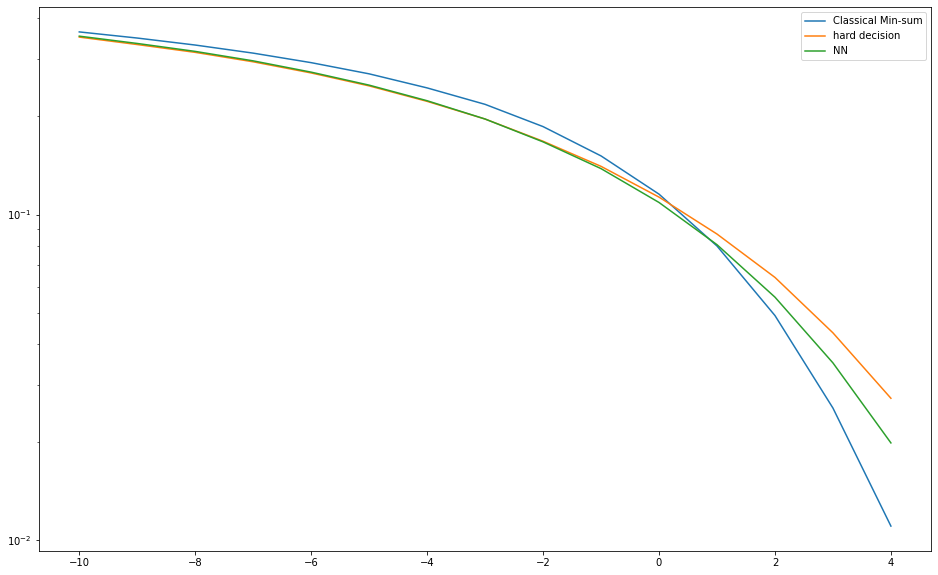

In [26]:
plt.figure(figsize=(16,10))
plt.semilogy(SNRs, bit_errors_min_sum.cpu() / nb_bits_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, bit_errors_hard.cpu() / nb_bits_hard.cpu(), label='hard decision')
# for i in range(10):
plt.semilogy(SNRs, bit_errors_nn[-1].cpu() / nb_bits_nn[-1].cpu(), label=f'NN')
plt.legend()
plt.show()

In [ ]:
decoder(soft_input)[0] - 0.5

In [ ]:
codewords[0]

In [27]:
decoder.W_vc

Parameter containing:
tensor([[0.2038, 0.9779, 0.3517, 1.2465, 0.9717, 0.6680, 1.1489, 1.0787, 0.3931,
         1.2662, 0.4653, 0.5294, 0.8220, 0.4791, 1.0745, 0.4185, 1.4206, 0.2584,
         0.5221, 0.4761, 0.1689, 0.4158, 1.5419, 0.6820, 0.4613, 0.9555, 0.5984,
         1.2517, 0.5022, 0.2860, 0.2079, 0.3327],
        [0.5957, 1.3633, 2.4112, 0.7175, 0.8736, 0.4473, 1.1076, 0.2477, 1.9485,
         1.3505, 0.9901, 0.1801, 1.9469, 0.1277, 1.0652, 0.2618, 0.4278, 0.5668,
         2.5399, 0.4197, 0.5171, 0.4156, 0.3437, 0.5380, 1.2933, 0.7777, 0.4102,
         0.1844, 0.1379, 2.4788, 0.1754, 0.1718],
        [0.7877, 0.1807, 1.1970, 0.5416, 1.2898, 1.5970, 0.1783, 1.1209, 0.6569,
         0.0106, 0.9526, 0.3103, 0.9193, 1.8266, 1.7590, 0.4051, 0.7603, 0.2082,
         0.5151, 0.5557, 0.4932, 1.5203, 0.2121, 0.5756, 0.3115, 0.1618, 0.5589,
         1.6786, 1.0974, 0.8508, 0.0258, 0.5636],
        [0.2573, 0.3973, 0.3431, 0.5708, 0.9939, 0.4531, 0.3641, 0.3119, 0.4835,
         0.2493, 0

In [30]:
decoder.B_cv

Parameter containing:
tensor([[9.7788e-02, 3.0606e-01, 8.1836e-01, 1.5221e+00, 1.2232e-01, 1.0805e+00,
         3.0746e-01, 1.3477e-01, 5.6197e-01, 2.7157e-01, 1.2746e+00, 9.4963e-02,
         4.0784e-02, 2.0885e-01, 1.6685e-01, 9.3342e-01, 2.6560e-01, 5.8321e-01,
         9.0237e-01, 8.0817e-01, 9.8762e-01, 4.8169e-01, 1.5190e+00, 1.0007e+00,
         6.0151e-01, 8.2788e-01, 1.8923e+00, 7.7931e-01, 7.2318e-01, 7.4211e-02,
         2.9535e-01, 3.7448e-01],
        [1.6626e+00, 8.1514e-02, 6.2852e-01, 5.4060e-01, 1.1040e-02, 1.2836e+00,
         1.1020e+00, 3.5296e-02, 1.6013e+00, 1.4390e+00, 6.7058e-01, 7.5651e-01,
         3.1549e+00, 1.2850e+00, 4.6024e-02, 1.1690e-01, 5.1540e-01, 9.2904e-01,
         1.2237e+00, 2.1575e+00, 3.6974e-01, 1.7269e+00, 5.1770e-01, 8.9102e-01,
         2.1727e+00, 3.5381e-01, 1.4353e+00, 2.9419e+00, 7.2109e-01, 1.7871e+00,
         5.4785e-01, 5.1022e-01],
        [1.6232e-01, 2.5117e-01, 8.0508e-01, 1.2322e+00, 5.2574e-02, 5.8200e-01,
         4.6076e-01